<a href="https://colab.research.google.com/github/thayportellads/Predict_Churn-Telco/blob/main/Churn_Telco_tcc_mba_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Criando modelos de Machine Learning para detectar churn de clientes de Telecom

### [BASE](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset)
TCC DSA - Script do trabalho

### Descrição de Dados: 7.043 observações com 33 variáveis



In [ ]:
!pip install scikit-plot -q

In [ ]:
# importar as bibliotecas necessárias
import pandas             as pd     # manipulação de dados
import numpy              as np     # manipulação de arrays
import matplotlib.pyplot  as plt    # visualização de dados
import seaborn            as sns    # visualização estatística dos dados
import warnings                     # notificações
warnings.filterwarnings('ignore')   # configurar notificações para serem ignoradas

from sklearn.preprocessing    import LabelEncoder           # transformação de dados categóricos
from sklearn.model_selection  import train_test_split       # divisão em conjuntos de treino e teste
from sklearn.pipeline         import make_pipeline          # construção de fluxo de trabalho
from sklearn.model_selection  import cross_val_score        # avaliação de desempenho por cross-validation
from sklearn.preprocessing    import StandardScaler         # normalização dos dados
from imblearn.over_sampling import SMOTE, RandomOverSampler    # balanceamento dos dados
from sklearn.model_selection import cross_validate  #Validação Cruzada
from sklearn.model_selection  import StratifiedKFold        # avaliação de desempenho com dados estratificados
from sklearn.model_selection import GridSearchCV            # criação de grade para avaliar hiperparâmetros
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay,roc_auc_score # avaliação de desempenho por f1, recall, matrix de confusão, AUC e acurácia

# modelos de classificação de dados
from sklearn.ensemble         import RandomForestClassifier
from sklearn.linear_model     import LogisticRegression
from xgboost                  import XGBClassifier

In [ ]:
# importar os dados
df_telco = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/Telco_customer_churn.xlsx')
df_telco.head(3)

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   

                 Lat Long   Latitude   Longitude  Gender  ...  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...   

  Streaming Movies        Contract Paperless Billing    Payment Method  \
0               No  Month-to-month               Yes      Mailed check   
1               No  Month-to-month               Yes  Electronic check   
2              Yes  Month-to-month               Yes  Electronic check   

  Monthly Charges Total Charges Churn Label Churn Score  CLTV  \
0           53.85        108.15         Yes          86  3239   
1           70.70        151.65         Yes          67  2701   
2           99.65         820.5         Yes          86  5372   

                   Churn Reason  
0  Competitor made better offer  
1                         Moved  
2                         Moved  

[3 rows x 32 columns]

In [ ]:
# verificando as informações da base de dados
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [ ]:
#verificando se existem colunas com valores ausentes
df_telco.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [ ]:
## Padronizando o nome de colunas
df_telco.columns = df_telco.columns.str.replace(' ','')
df_telco.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'ZipCode', 'LatLong',
       'Latitude', 'Longitude', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'TenureMonths', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'ChurnLabel', 'ChurnScore', 'CLTV', 'ChurnReason'],
      dtype='object')

In [ ]:
# Avaliando a coluna Total Charges e transformando valores faltantes em zero
df_telco.loc[(df_telco['TotalCharges'] == " "), 'TotalCharges']=0
print(len(df_telco.loc[df_telco['TotalCharges'] == " "]))

0


In [ ]:
# Transformando a coluna Total Charges em valores númericos float
df_telco['TotalCharges'] = pd.to_numeric(df_telco['TotalCharges'], errors='coerce')
df_telco.dtypes

CustomerID           object
Count                 int64
Country              object
State                object
City                 object
ZipCode               int64
LatLong              object
Latitude            float64
Longitude           float64
Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
TenureMonths          int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
ChurnLabel           object
ChurnScore            int64
CLTV                  int64
ChurnReason          object
dtype: object

In [ ]:
#Checando valores unicos de entrada para cada atributo
df_telco.nunique()

CustomerID          7043
Count                  1
Country                1
State                  1
City                1129
ZipCode             1652
LatLong             1652
Latitude            1652
Longitude           1651
Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
TenureMonths          73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
ChurnLabel             2
ChurnScore            85
CLTV                3438
ChurnReason           20
dtype: int64

In [ ]:
df_telco['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [ ]:
# Organizar as cidades removendo espaços em branco, padronizando o dado
df_telco['City'].replace(' ','',regex= True, inplace =True)
df_telco['City'].unique()

array(['LosAngeles', 'BeverlyHills', 'HuntingtonPark', ..., 'Standish',
       'Tulelake', 'OlympicValley'], dtype=object)

In [ ]:
# Avaliando as colunas com mais 3 de váriaveis categoricas para realizar transformações necessárias
##  É possivel observar que existem váriaveis com opção de 3 ou 4 respostas, para essas variaveis vamos separar o conjunto por atributos e depois categorizar por sim ou não

# Criando as variaveis com atributos de entradas únicas:

val_unique = df_telco[['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']]

# Definir resultados para cada atributo, através da função
for i in val_unique:
  print(f'{df_telco[i].unique()}')

['No' 'Yes' 'No phone service']
['DSL' 'Fiber optic' 'No']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [ ]:
## Removendo váriaveis que contem informações irrelevantes para o modelo, como ID do cliente. state, count, country
df_telco.drop(['CustomerID', 'Count', 'State', 'Country', 'LatLong', 'ZipCode', 'Latitude', 'Longitude', 'CLTV', 'ChurnScore'], axis=1, inplace =True)

In [ ]:
#verificando a estatistica dos dados
df_telco.describe()

TenureMonths  MonthlyCharges  TotalCharges
count   7043.000000     7043.000000   7043.000000
mean      32.371149       64.761692   2279.734304
std       24.559481       30.090047   2266.794470
min        0.000000       18.250000      0.000000
25%        9.000000       35.500000    398.550000
50%       29.000000       70.350000   1394.550000
75%       55.000000       89.850000   3786.600000
max       72.000000      118.750000   8684.800000

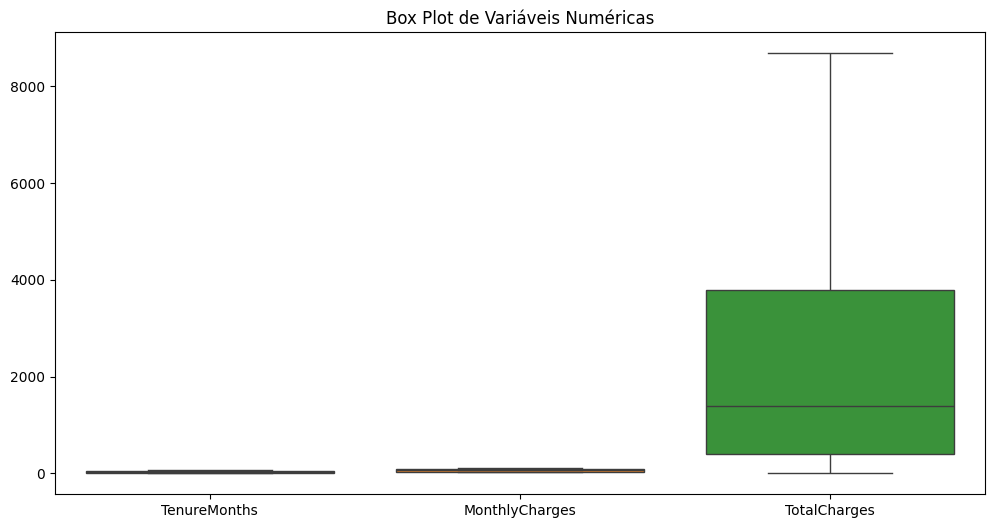

In [ ]:
# Criando o box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_telco[['TenureMonths', 'MonthlyCharges', 'TotalCharges']])
plt.title('Box Plot de Variáveis Numéricas')
plt.show()


É possível observar que existe um grande desbalanceamento entre as variáveis númericas, convém padroniza-las para não influenciar o modelo na decisão

# Análise exploratória dos dados através de gráficos

ChurnLabel
No     5174
Yes    1869
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

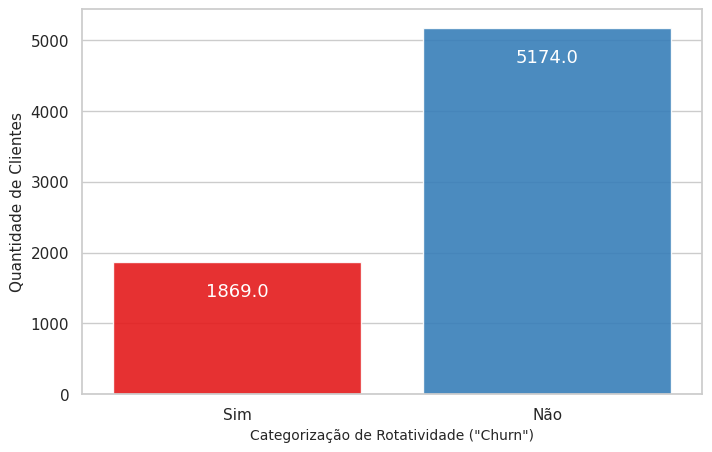

In [ ]:
## Plotar gráfico
# Contar a frequência de categorias na coluna categórica
display(df_telco['ChurnLabel'].value_counts())

plt.figure(facecolor='White')
sns.set(style='whitegrid')
plt.figure(figsize=(8,5), facecolor='White')
ax = sns.countplot(data=df_telco, x='ChurnLabel', saturation=1, alpha=0.9, palette='Set1')
ax.set_xlabel('Churn', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax.set_xticklabels(['Sim', 'Não'])

plt.xlabel('Categorização de Rotatividade ("Churn")', fontsize=10)
plt.ylabel('Quantidade de Clientes', fontsize=11)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='white', size=13)

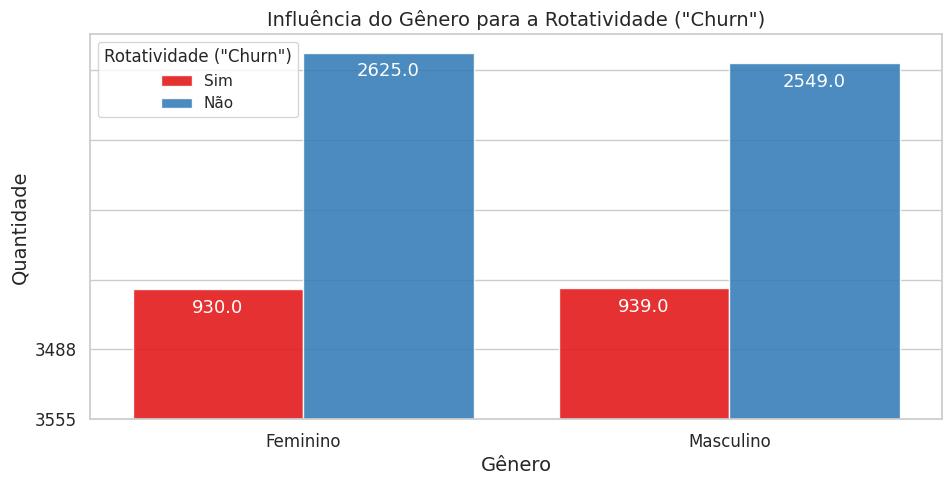

In [ ]:
# Checando relação de Gender com o Churn
if 'Gender' in df_telco.columns and 'ChurnLabel' in df_telco.columns:

    x = ['Feminino', 'Masculino']
    y = df_telco.Gender.value_counts()

    plt.figure(figsize=(11, 5), facecolor='white')
    sns.set(style='whitegrid')
    ax = sns.countplot(data=df_telco, x='Gender', hue='ChurnLabel', saturation=1, alpha=0.9, palette='Set1')

    ax.set_title('Influência do Gênero para a Rotatividade ("Churn")', fontsize=14)

    ax.set_xlabel('Gênero', fontsize=12)
    ax.set_ylabel('Quantidade', fontsize=12)
    ax.legend(['Sim', 'Não'], title='Rotatividade ("Churn")', fontsize=11)
    plt.xlabel('Gênero', fontsize=14)
    plt.ylabel('Quantidade', fontsize=14)

    ax.set_xticklabels(x, fontsize=12)
    ax.set_yticklabels(y, fontsize=12)

    # Adicionando rótulos de quantidade e porcentagem
    total = len(df_telco)
    for p in ax.patches:
         ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=13, xytext=(0, 8),
                    textcoords='offset points')

plt.show()

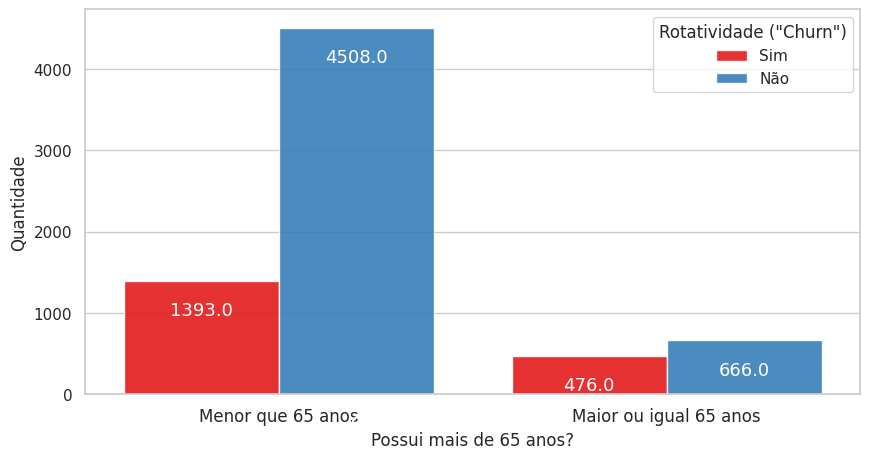

In [ ]:
# Checando a variavel Senior Citizen
plt.figure(figsize=(10,5), facecolor='white')
sns.set(style='whitegrid')
ax = sns.countplot(data=df_telco, x='SeniorCitizen', hue='ChurnLabel', saturation=1, alpha=0.9, palette='Set1')
plt.xlabel('Possui mais de 65 anos?')
plt.ylabel('Quantidade')
ax.set_xticklabels(['Menor que 65 anos', 'Maior ou igual 65 anos'], fontsize=12)

for p in ax.patches:
  ax.legend(['Sim', 'Não'], title='Rotatividade ("Churn")')
  ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=13)
plt.show()

<Figure size 1200x500 with 0 Axes>

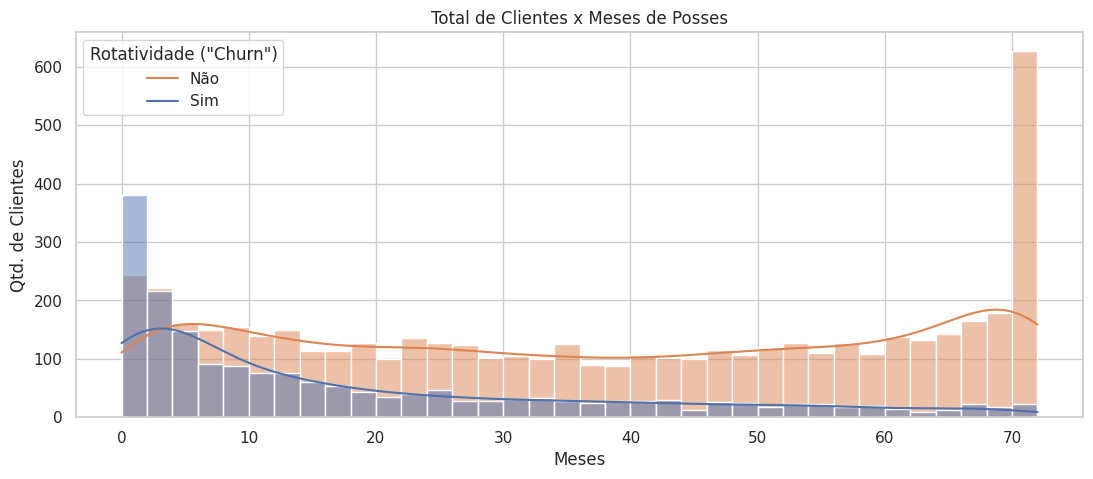

In [ ]:
# Checando a variável tempo como Cliente
plt.figure(figsize=(12,5), facecolor='white')

sns.set(style='whitegrid')

# Criar a figura
plt.figure(figsize=(13, 5), facecolor='white')

# Plotar o histograma com a linha KDE
sns.histplot(data=df_telco, x='TenureMonths', hue='ChurnLabel', binwidth=2, kde=True)

plt.title('Total de Clientes x Meses de Posses')
plt.xlabel('Meses')
plt.ylabel('Qtd. de Clientes')

# Ajustar a legenda
plt.legend(title='Rotatividade ("Churn")', labels=['Não', 'Sim'])

plt.show()

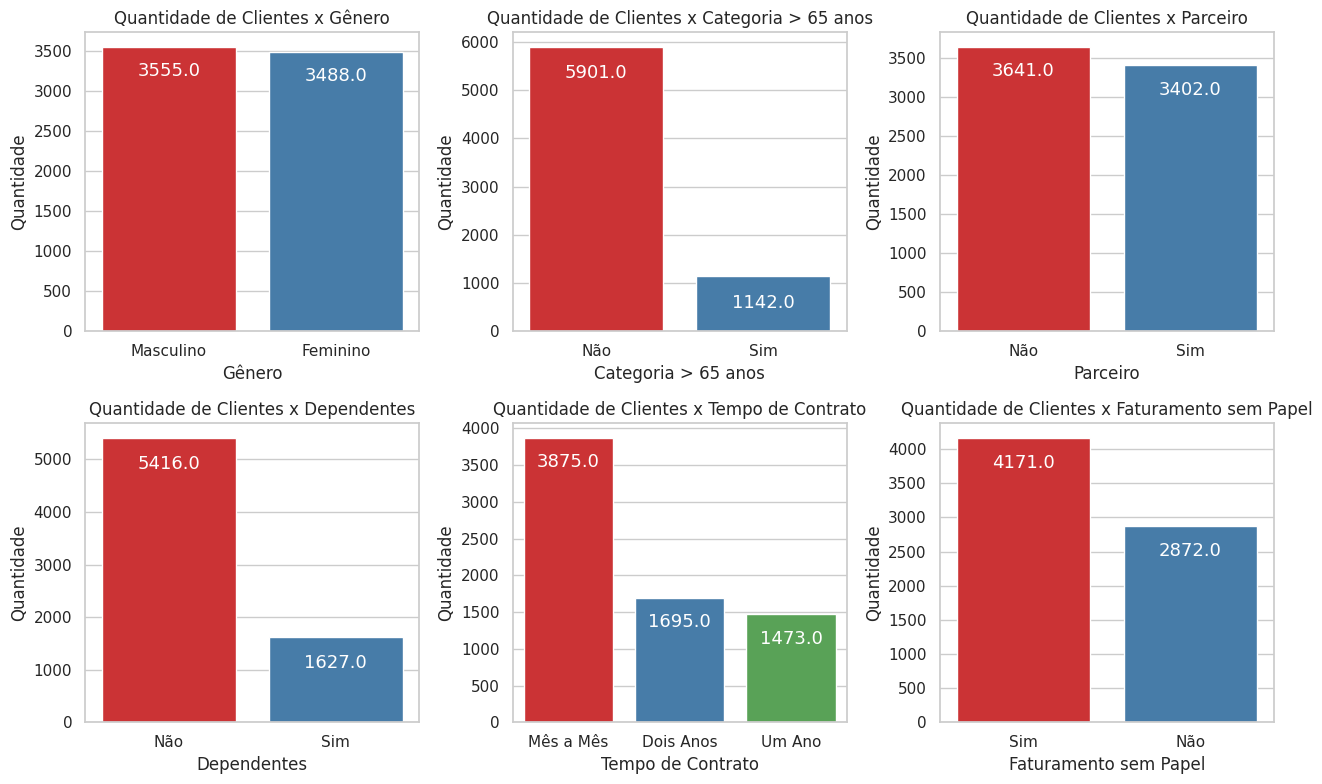

In [ ]:
# Dicionário de tradução
dict_pt = {
    "Gender": "Gênero",
    "SeniorCitizen": "Categoria > 65 anos",
    "Partner": "Parceiro",
    "Dependents": "Dependentes",
    "Contract": "Tempo de Contrato",
    "PaperlessBilling": "Faturamento sem Papel",
    "PaymentMethod": "Forma de Pagamento"
}

# Dicionário de tradução para os valores dos ticks
tick_dict_pt = {
    "Gender": {"Male": "Masculino", "Female": "Feminino"},
    "SeniorCitizen": {"Yes": "Sim", "No": "Não"},
    "Partner": {"Yes": "Sim", "No": "Não"},
    "Dependents": {"Yes": "Sim", "No": "Não"},
    "Contract": {"Month-to-month": "Mês a Mês", "One year": "Um Ano", "Two year": "Dois Anos"},
    "PaperlessBilling": {"Yes": "Sim", "No": "Não"},
    "PaymentMethod": {
        "Bank transfer (automatic)": "Saque Bancário",
        "Credit card (automatic)": "Cartão de Crédito",
        "Electronic check": "Cheque Eletrônico",
        "Mailed check": "Cheque Enviado"
    }
}

# Lista de colunas para plotar
cols = ["Gender", "SeniorCitizen", "Partner", "Dependents", "Contract", "PaperlessBilling", "PaymentMethod"]

# Definir o tamanho da figura e o número de colunas de subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

# Iterar sobre as colunas e os subplots
for ax, feature in zip(axes.flatten(), cols):
    sns.countplot(x=feature, data=df_telco, palette='Set1', ax=ax)
    ax.set_ylabel('Quantidade')
    ax.set_xlabel(dict_pt[feature])  # Adiciona o xlabel em português
    ax.set_title(f'Quantidade de Clientes x {dict_pt[feature]}')

    # Traduzir os rótulos dos ticks do eixo x:
    if feature in tick_dict_pt:
        tick_labels = [tick_dict_pt[feature].get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()]
        ax.set_xticklabels(tick_labels)

    # Adicionar anotações:
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 70), ha='center', va='top', color='white', size=13)

# Ajustar o layout para evitar sobreposição:
plt.tight_layout()
plt.show()

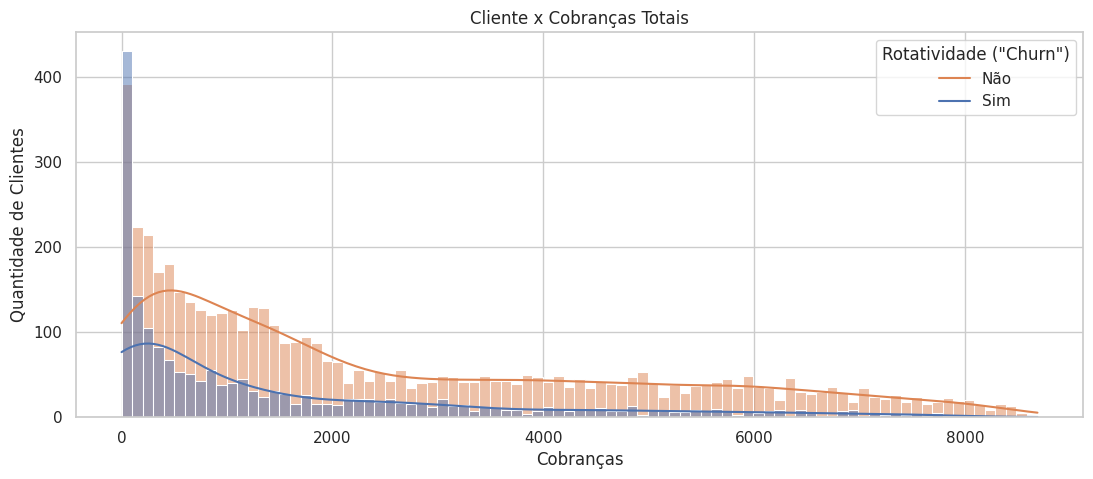

In [ ]:
# Checando a variável Cobrança total

sns.set(style='whitegrid')

# Criar a figura
plt.figure(figsize=(13, 5), facecolor='white')

# Plotar o histograma com a linha KDE
sns.histplot(data=df_telco, x='TotalCharges', hue='ChurnLabel', binwidth=100, kde=True)

# Definir título e rótulos traduzidos
plt.title('Cliente x Cobranças Totais')
plt.xlabel('Cobranças')
plt.ylabel('Quantidade de Clientes')

# Ajustar a legenda
plt.legend(title='Rotatividade ("Churn")', labels=['Não', 'Sim'])

# Mostrar o gráfico
plt.show()

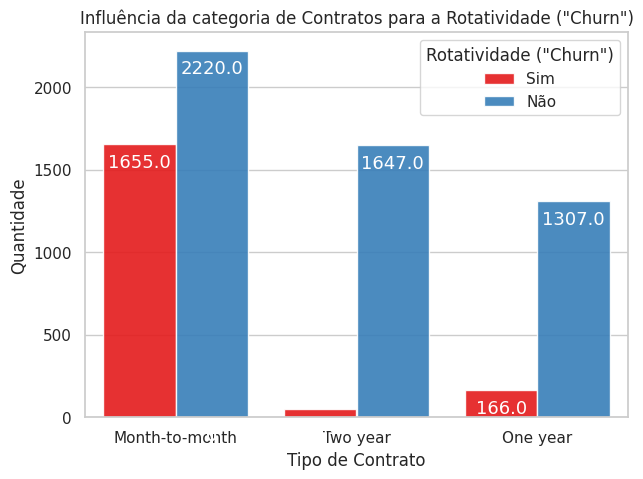

In [ ]:
# Checando a variavel Contrato (Formato de Tempo)
plt.figure(figsize=(7,5), facecolor='white')
sns.set(style='whitegrid')
ax = sns.countplot(data=df_telco, x='Contract', hue='ChurnLabel', order=df_telco['Contract'].value_counts().index, saturation=1, alpha=0.9, palette='Set1')
ax.set_title('Influência da categoria de Contratos para a Rotatividade ("Churn")')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Quantidade')
for p in ax.patches:
  ax.legend(['Sim', 'Não'], title='Rotatividade ("Churn")')
  ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()+70), ha='center', va='top', color='white', size=13)
plt.show()

In [ ]:
df_telco['ChurnReason'].unique()

array(['Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Competitor offered more data', 'Price too high',
       'Product dissatisfaction', 'Service dissatisfaction',
       'Lack of self-service on Website', 'Network reliability',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Extra data charges', "Don't know",
       'Poor expertise of online support',
       'Poor expertise of phone support', 'Attitude of service provider',
       'Attitude of support person', 'Deceased', nan], dtype=object)

In [ ]:
import plotly.express as px

# Defina o número de razões de churn a serem exibidas
top_n_reasons = 10

# Obtenha as top N razões de churn mais frequentes
churn_reasons_counts = df_telco['ChurnReason'].value_counts().head(top_n_reasons)

# Crie um dicionário de mapeamento para renomear as razões de churn
rename_dict = {
    'Competitor made better offer': 'Concorrente fez uma oferta melhor',
    'Moved': 'Mudou-se',
    'Competitor had better devices': 'Concorrente tinha dispositivos melhores',
    'Competitor offered higher download speeds': 'Concorrente ofereceu velocidades de download mais altas',
    'Competitor offered more data': 'Concorrente ofereceu mais dados',
    'Price too high': 'Preço muito alto',
    'Product dissatisfaction': 'Insatisfação com o produto',
    'Service dissatisfaction': 'Insatisfação com o serviço',
    'Lack of self-service on Website': 'Falta de autoatendimento no site',
    'Network reliability': 'Confiabilidade da rede',
    'Limited range of services': 'Gama limitada de serviços',
    'Lack of affordable download/upload speed': 'Falta de velocidade de download/upload acessível',
    'Long distance charges': 'Cobranças de longa distância',
    'Extra data charges': 'Cobranças adicionais de dados',
    "Don't know": 'Não sabe',
    'Poor expertise of online support': 'Pouca expertise do suporte online',
    'Poor expertise of phone support': 'Pouca expertise do suporte telefônico',
    'Attitude of service provider': 'Atitude do provedor de serviços',
    'Attitude of support person': 'Atitude da pessoa de suporte',
    'Deceased': 'Falecido',
    'Competitor made better offer': 'Concorrente fez uma oferta melhor'
}

# Renomeie as razões de churn no índice
churn_reasons_counts.rename(index=rename_dict, inplace=True)

# Extraia os rótulos e contagens das razões para o gráfico de barras
reason_labels = churn_reasons_counts.index.to_numpy()
reason_counts = churn_reasons_counts.to_numpy()

# Crie o gráfico de barras
fig = px.bar(x=reason_labels, y=reason_counts, color=reason_counts, text=churn_reasons_counts)

# Atualize o layout do gráfico
fig.update_layout(
    title='Razões de Rotatividade ("Churn") (Frequência)',
    xaxis_title="Razão do Churn",
    yaxis_title="Número de Clientes",
)

# Exiba o gráfico
fig.show()

# Identificando Padrões entre variaveis Categoricas:

In [ ]:
# Criando o Dataframe dos 9 serviços:
services = df_telco[['PhoneService','MultipleLines','InternetService',
               'OnlineSecurity','OnlineBackup','DeviceProtection',
               'TechSupport','StreamingTV','StreamingMovies']]
# transformando categorias em 1 ou 0:
services['PhoneService'] = services['PhoneService'].map({'Yes':1,'No':0})
for item in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
  services[item] = services[item].map({'Yes':1,'No internet service':0,'No':0})
services['MultipleLines'] = services['MultipleLines'].map({'Yes':1,'No':0,'No phone service':0})
services['InternetService'] = services['InternetService'].map({'DSL':1,'Fiber optic':1,'No':0})
services.head()

PhoneService  MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0             1              0                1               1             1   
1             1              0                1               0             0   
2             1              1                1               0             0   
3             1              1                1               0             0   
4             1              1                1               0             1   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
0                 0            0            0                0  
1                 0            0            0                0  
2                 1            0            1                1  
3                 1            1            1                1  
4                 1            0            1                1

In [ ]:
# Adicionando os valores de cada linha para criar uma nova coluna
services['total_services'] = services.sum(axis=1)

# Transferindo a coluna para o dataframe original
df_telco = pd.concat([df_telco, services['total_services']], axis=1)

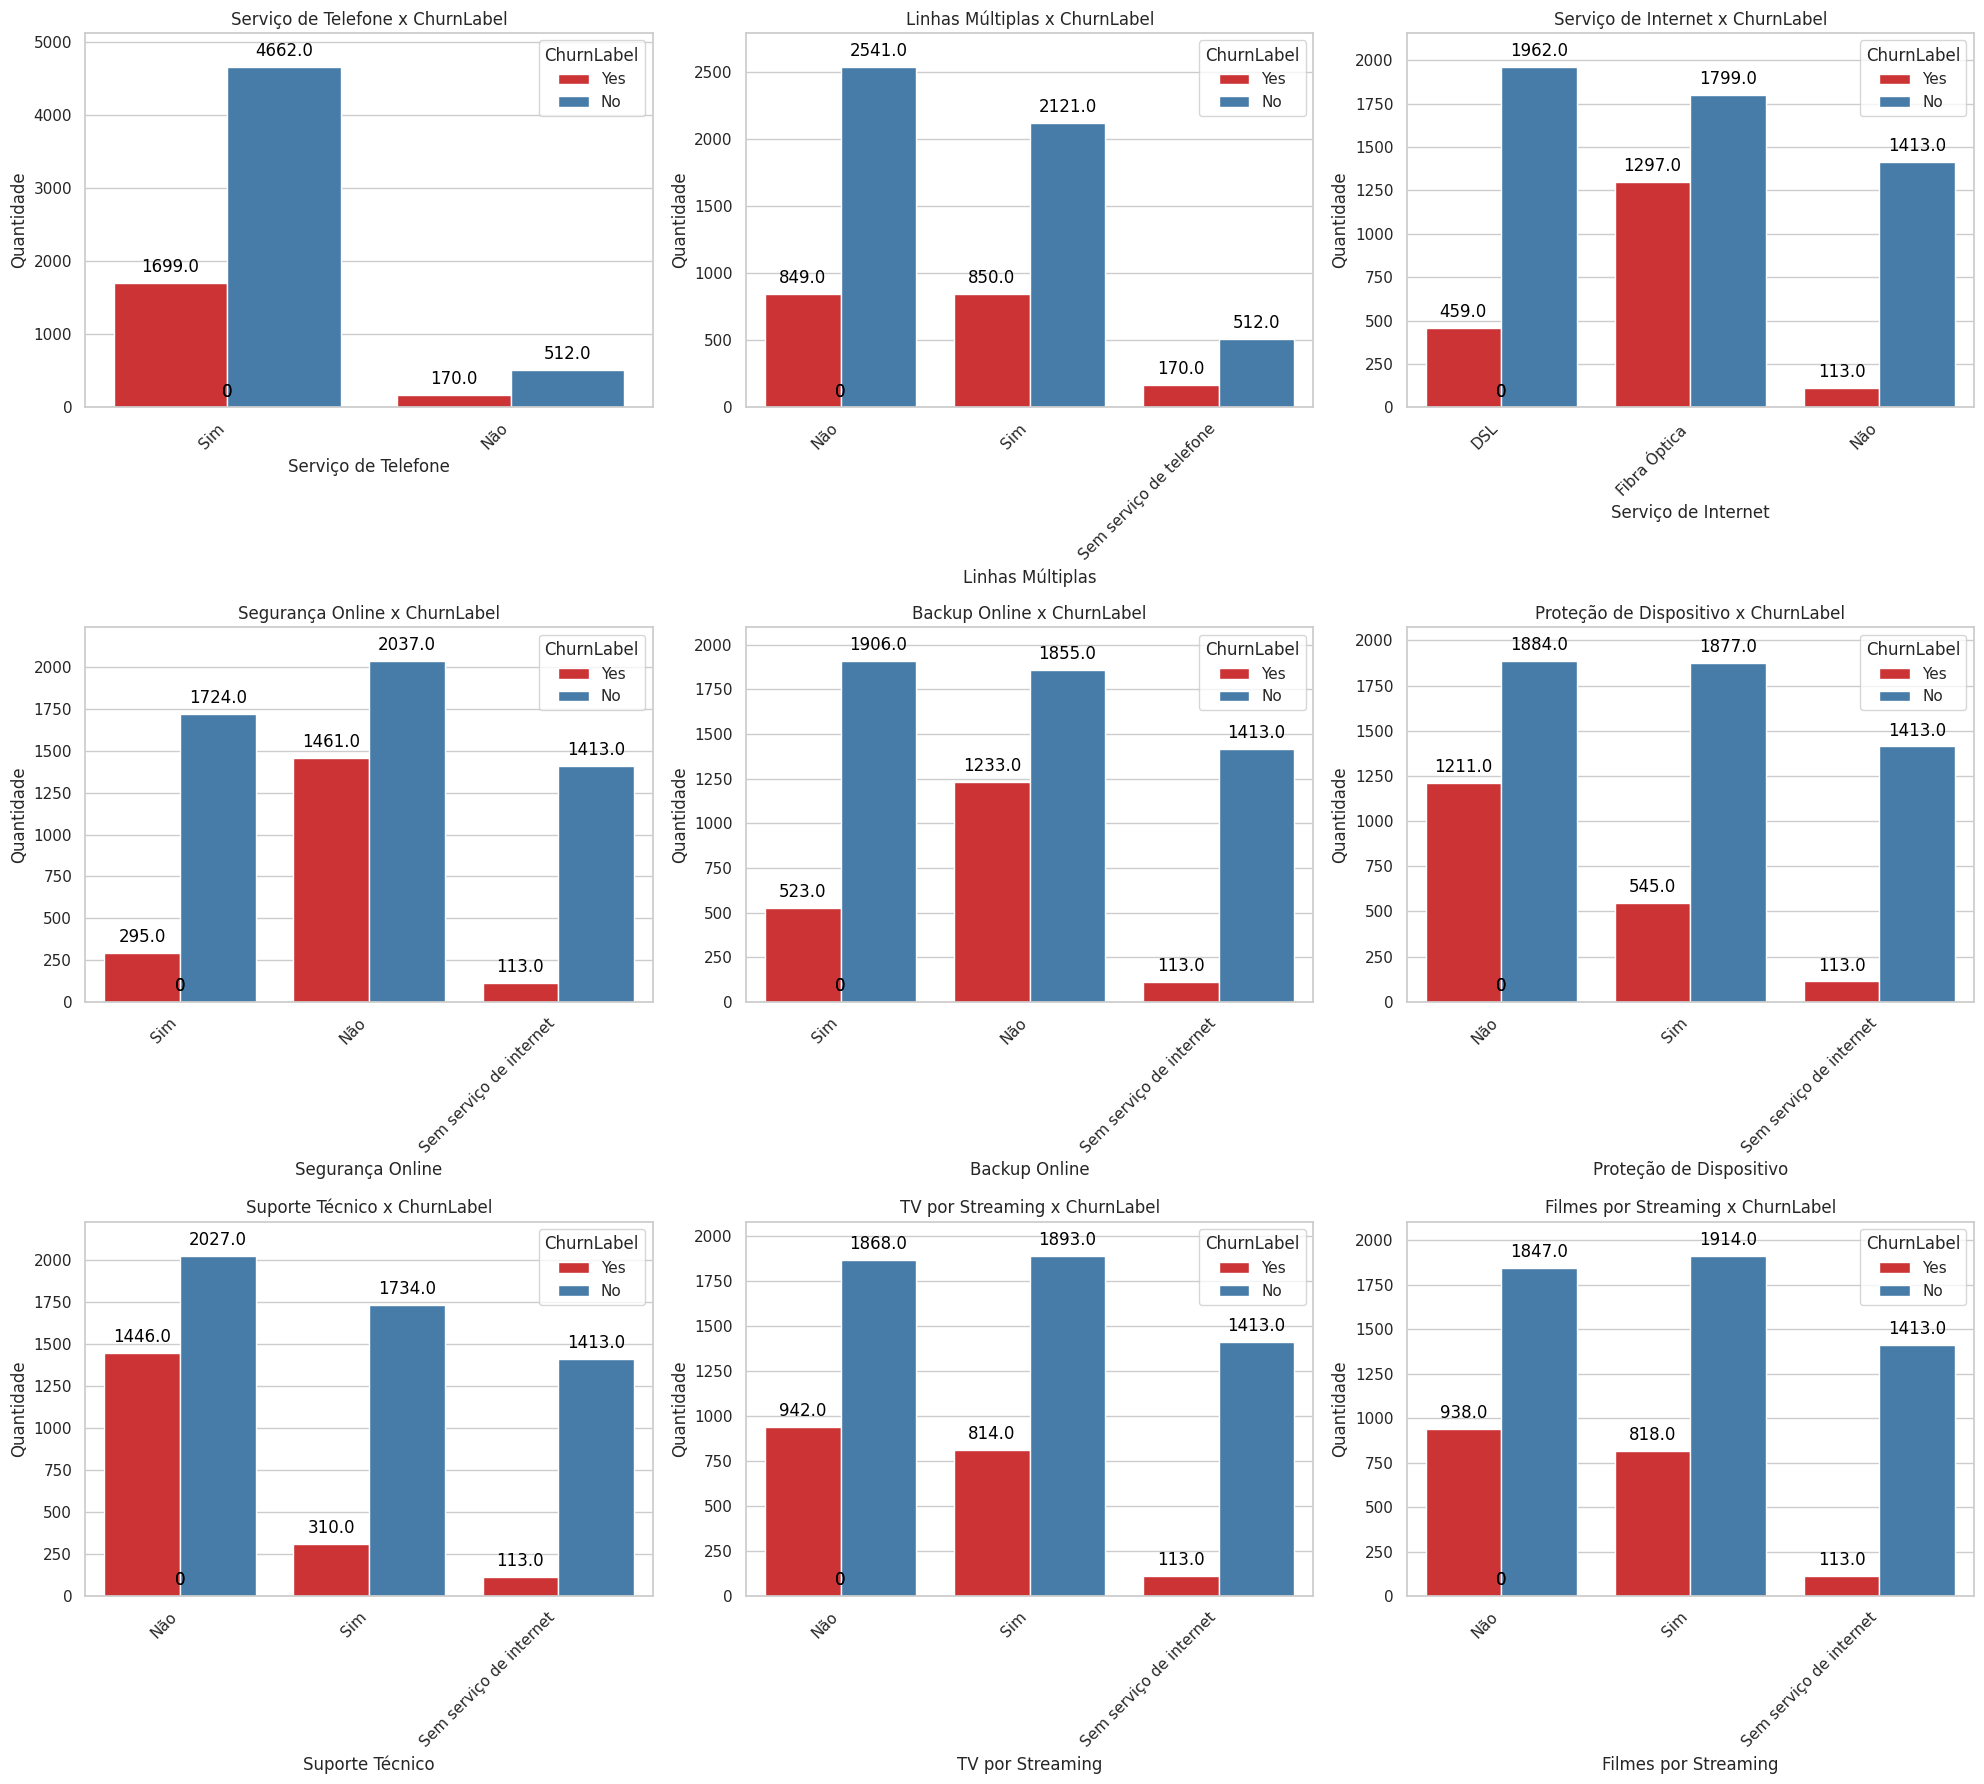

In [ ]:
def plot_categorical_to_target(df, categorical_columns, target_column):
    # Defina o número de colunas de subplots
    n_cols = 3
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

    # Ajuste o tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 6))

    # Dicionário de mapeamento para títulos personalizados
    title_pt = {
        "PhoneService": "Serviço de Telefone",
        "MultipleLines": "Linhas Múltiplas",
        "InternetService": "Serviço de Internet",
        "OnlineSecurity": "Segurança Online",
        "OnlineBackup": "Backup Online",
        "DeviceProtection": "Proteção de Dispositivo",
        "TechSupport": "Suporte Técnico",
        "StreamingTV": "TV por Streaming",
        "StreamingMovies": "Filmes por Streaming"
    }

    # Dicionário de tradução para os valores dos ticks (se necessário)
    tick_pt = {
        "PhoneService": {"Yes": "Sim", "No": "Não"},
        "MultipleLines": {"Yes": "Sim", "No": "Não", "No phone service": "Sem serviço de telefone"},
        "InternetService": {"DSL": "DSL", "Fiber optic": "Fibra Óptica", "No": "Não"},
        "OnlineSecurity": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"},
        "OnlineBackup": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"},
        "DeviceProtection": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"},
        "TechSupport": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"},
        "StreamingTV": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"},
        "StreamingMovies": {"Yes": "Sim", "No": "Não", "No internet service": "Sem serviço de internet"}
    }

    # Iterar sobre as colunas categóricas e os subplots
    for ax, feature in zip(axes.flatten(), categorical_columns):
        sns.countplot(x=feature, hue=target_column, data=df, palette='Set1', ax=ax)
        ax.set_ylabel('Quantidade')
        ax.set_xlabel(title_pt.get(feature, feature))  # Adiciona o xlabel em português
        ax.set_title(f'{title_pt.get(feature, feature)} x {target_column}')

        # Traduzir os rótulos dos ticks do eixo x, se necessário
        if feature in tick_pt:
            tick_labels = [tick_pt[feature].get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()]
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')

        # Adicionar anotações com contagens na extremidade superior das barras
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

        # Ajustar os limites do eixo y para dar mais espaço acima das barras
        max_height = max([p.get_height() for p in ax.patches])
        ax.set_ylim(0, max_height * 1.1)

    # Remover subplots vazios
    for ax in axes.flatten()[len(categorical_columns):]:
        fig.delaxes(ax)

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

# Lista de serviços de clientes
customer_services = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                     "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Chamar a função para plotar os gráficos
plot_categorical_to_target(df_telco, customer_services, "ChurnLabel")

Análisando os serviços, existe um relação similar para a categoria "Sem serviço de internet" entre 7 variaveis('OnlineBackup', 'OnlineSecurity', 'PaperlessBilling','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'), onde todas apresentam 113 resultados.
Avaliando a variavel Phone Service e Multiplelines, existe uma categoria similiar entre elas, que corresponde ao mesmo número de linhas.

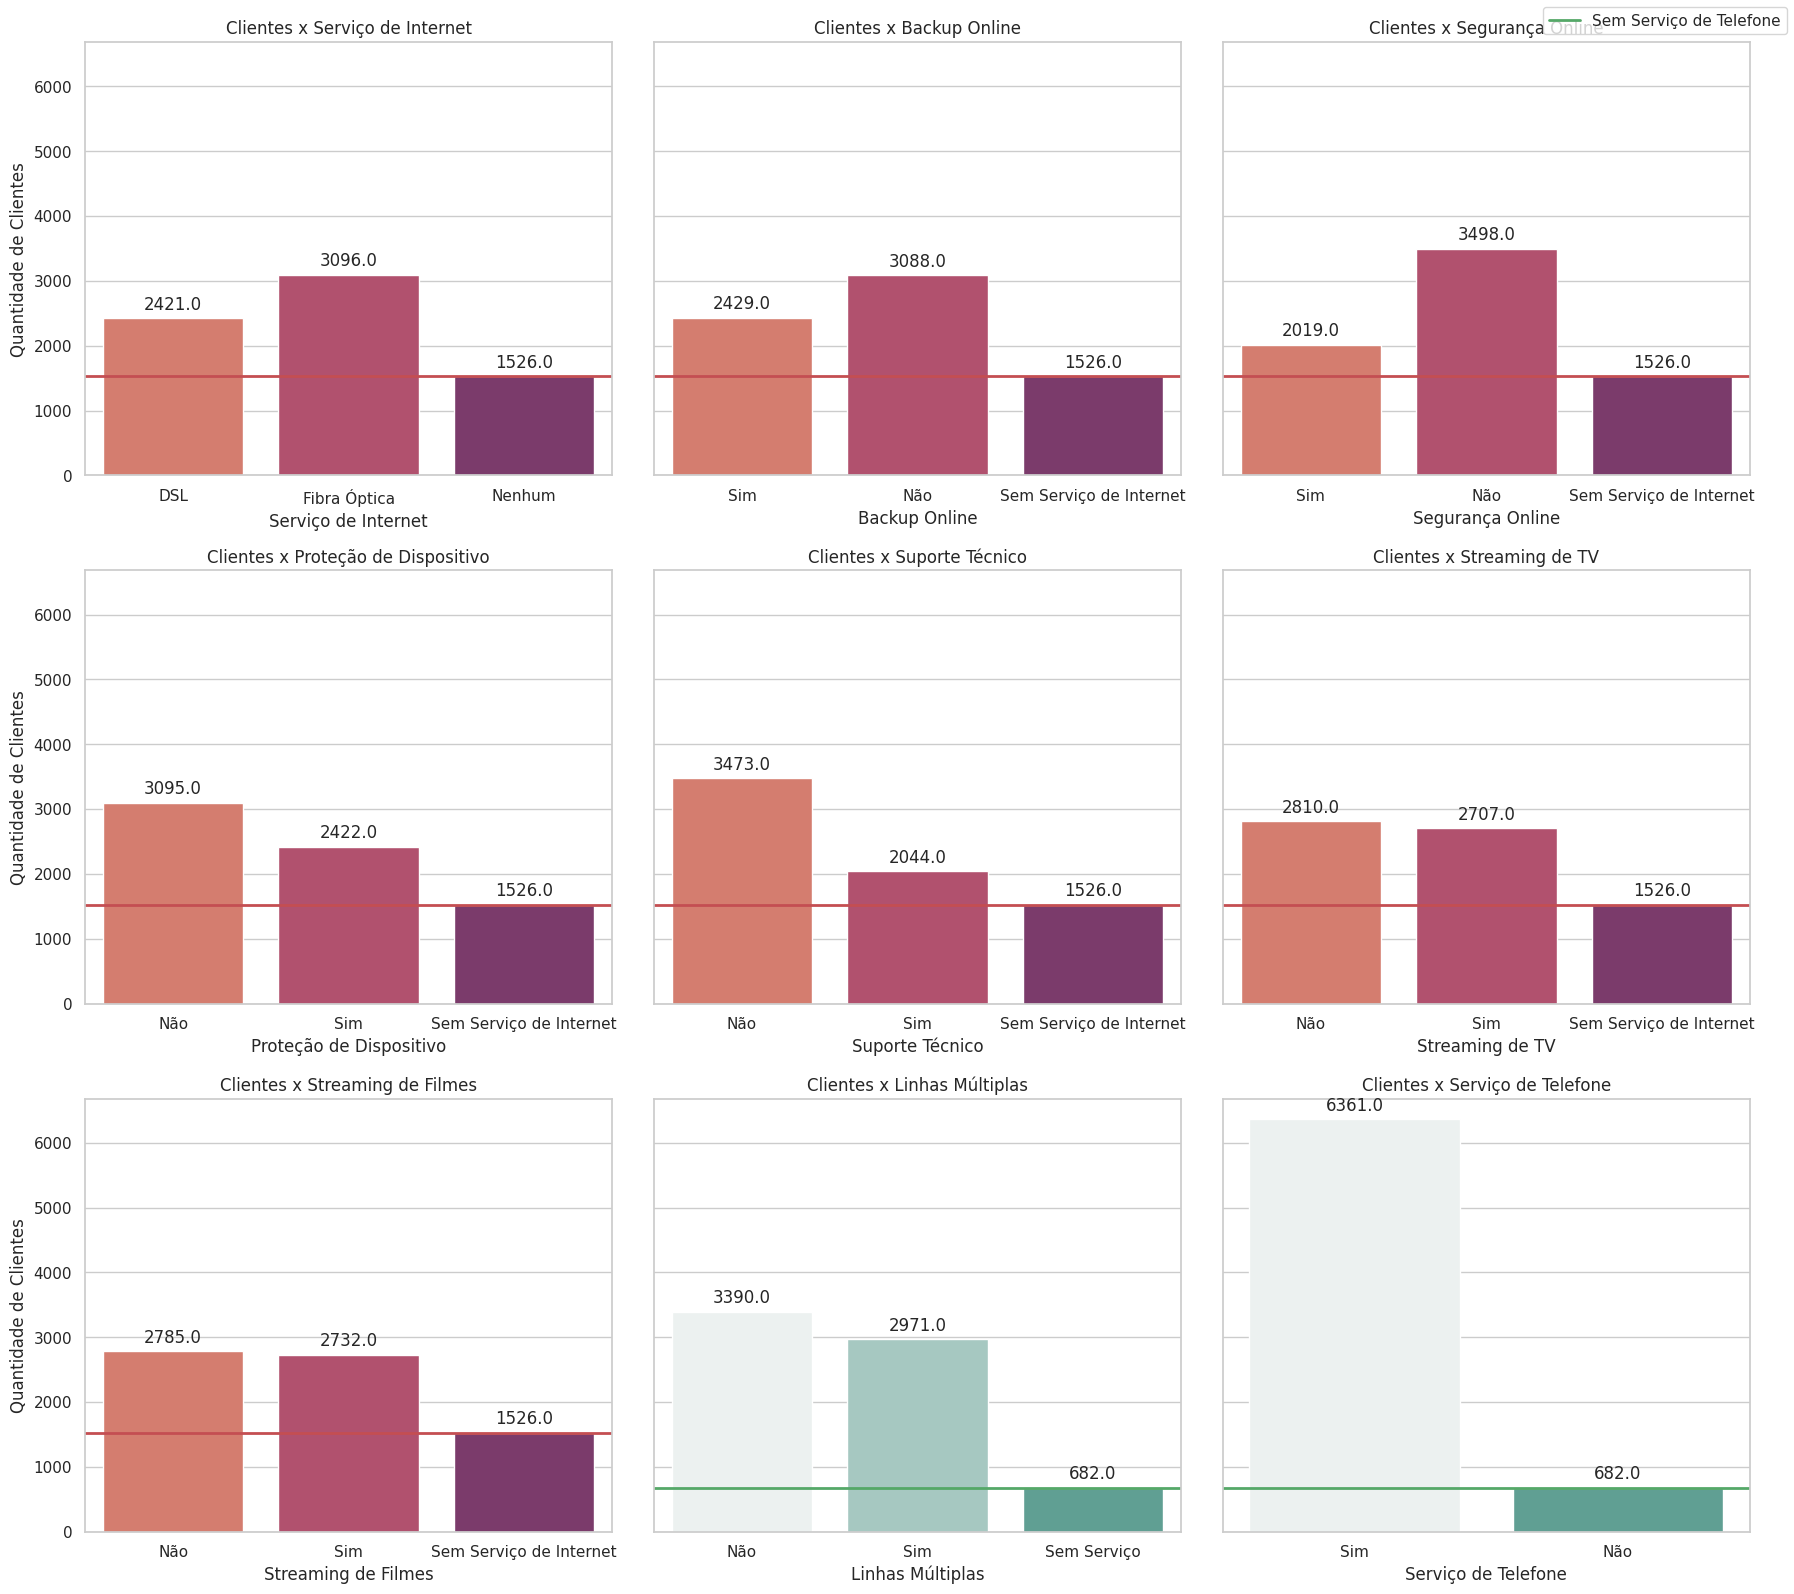

In [ ]:

# Dicionário de tradução para os nomes das variáveis
dict_pt = {
    'MultipleLines': 'Linhas Múltiplas',
    'PhoneService': 'Serviço de Telefone',
    'InternetService': 'Serviço de Internet',
    'OnlineBackup': 'Backup Online',
    'OnlineSecurity': 'Segurança Online',
    'DeviceProtection': 'Proteção de Dispositivo',
    'TechSupport': 'Suporte Técnico',
    'StreamingTV': 'Streaming de TV',
    'StreamingMovies': 'Streaming de Filmes'
}

# Dicionário de tradução para os valores dos ticks
tick_dict_pt = {
    'MultipleLines': {'No': 'Não', 'Yes': 'Sim', 'No phone service': 'Sem Serviço'},
    'PhoneService': {'No': 'Não', 'Yes': 'Sim'},
    'InternetService': {'No': 'Nenhum', 'DSL': 'DSL', 'Fiber optic': 'Fibra Óptica'},
    'OnlineBackup': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
    'OnlineSecurity': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
    'DeviceProtection': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
    'TechSupport': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
    'StreamingTV': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
    'StreamingMovies': {'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem Serviço de Internet'},
}

# Definindo as variáveis categóricas
cat = ['InternetService', 'OnlineBackup', 'OnlineSecurity', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'PhoneService']

# Criar a figura e os eixos
fig, axes = plt.subplots(3, 3, figsize=(18, 16), sharey=True)

# Contagem de serviços
No_Int_Serv = df_telco['InternetService'].value_counts().get('No', 0)
No_Phone_Serv = df_telco['PhoneService'].value_counts().get('No', 0)

# Função para adicionar rótulos de valor nas barras
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points')

# Contagem de gráficos
i = 0
for row in range(3):
    for column in range(3):
        if i >= len(cat):
            break


        # Adicionar linha horizontal se necessário
        if cat[i] == 'InternetService':
            ax = sns.countplot(x=cat[i], data=df_telco, ax=axes[row, column], palette='flare')
            axes[row, column].axhline(y=No_Int_Serv, linewidth=2, color='r', label='Sem Serviço')
        elif cat[i] in ['OnlineBackup', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
            ax = sns.countplot(x=cat[i], data=df_telco, ax=axes[row, column], palette='flare')
            axes[row, column].axhline(y=No_Int_Serv, linewidth=2, color='r', label='Sem Serviço de Internet')
        elif cat[i] == 'MultipleLines':
            ax = sns.countplot(x=cat[i], data=df_telco, ax=axes[row, column], palette='light:#5A9')
            axes[row, column].axhline(y=No_Phone_Serv, linewidth=2, color='g', label='Sem Serviço')
        elif cat[i] == 'PhoneService':
            ax = sns.countplot(x=cat[i], data=df_telco, ax=axes[row, column], palette='light:#5A9')
            axes[row, column].axhline(y=No_Phone_Serv, linewidth=2, color='g', label='Sem Serviço de Telefone')

        # Adicionar rótulos de valor
        add_value_labels(ax)

        # Traduzir rótulos e título
        axes[row, column].set_title(f'Clientes x {dict_pt[cat[i]]}')
        axes[row, column].set_xlabel(dict_pt[cat[i]])
        axes[row, column].set_ylabel('Quantidade de Clientes')

        # Traduzir os rótulos dos ticks do eixo x
        if cat[i] in tick_dict_pt:
            tick_labels = [tick_dict_pt[cat[i]].get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()]
            ax.set_xticklabels(tick_labels)

        i += 1

# Ajustar layout e adicionar legenda
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right')
plt.show()

Compreensão da Correlação entre as variaveis PhoneService e Multiplelines

In [ ]:
pd.crosstab(df_telco['PhoneService'],df_telco['MultipleLines'])

MultipleLines    No  No phone service   Yes
PhoneService                               
No                0               682     0
Yes            3390                 0  2971

In [ ]:
df_telco[df_telco['InternetService']=='No'][['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].value_counts()

OnlineSecurity       OnlineBackup         DeviceProtection     TechSupport          StreamingTV          StreamingMovies    
No internet service  No internet service  No internet service  No internet service  No internet service  No internet service    1526
Name: count, dtype: int64

In [ ]:
df_telco['total_services']

0       4
1       2
2       6
3       7
4       7
       ..
7038    1
7039    8
7040    7
7041    2
7042    7
Name: total_services, Length: 7043, dtype: int64

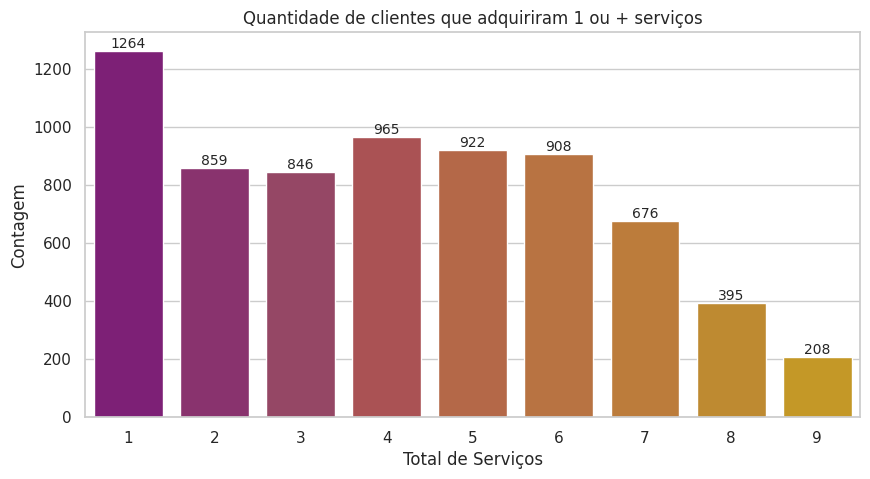

In [ ]:
# gráfico de contagem
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='total_services', data=df_telco, palette=sns.color_palette([
    "#8C1084", "#972573", "#A23A62", "#B84446", "#C66136",
    "#CC6F2E", "#D17C26", "#D69019", "#DEA40D", "#E6B800"
]))

# Adicionar contagem acima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Adicionar título e rótulos
plt.title('Quantidade de clientes que adquiriram 1 ou + serviços')
plt.xlabel('Total de Serviços')
plt.ylabel('Contagem')

# Mostrar o gráfico
plt.show()

Considerando o Gráfico acima, existem mais clientes que adquiriram poucos serviços

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Função para calcular a porcentagem de clientes que possuem e não possuem cada serviço
def calculate_service_statistics(df, service_columns, target_column):
    statistics = {'Serviço': [], 'Possuem (%)': [], 'Não possuem (%)': [], 'Correlação com Churn': []}

    for service in service_columns:
        total = len(df_telco)
        have_service = df_telco[service].apply(lambda x: x != 'No' and x != 'No phone service' and x != 'No internet service').sum()
        no_service = total - have_service

        # Convertendo valores "Yes" e "No" para 1 e 0 antes de calcular a correlação
        service_numeric = df_telco[service].apply(lambda x: 1 if x != 'No' and x != 'No phone service' and x != 'No internet service' else 0)

        # Convertendo a coluna alvo para valores numéricos
        target_numeric = df_telco[target_column].apply(lambda x: 1 if x == 'Yes' else 0)

        correlation = service_numeric.corr(target_numeric)

        statistics['Serviço'].append(service)
        statistics['Possuem (%)'].append(have_service / total * 100)
        statistics['Não possuem (%)'].append(no_service / total * 100)
        statistics['Correlação com Churn'].append(correlation)

    return pd.DataFrame(statistics)

# Função para plotar gráficos categóricos
def plot_categorical_to_target(df, categorical_columns, target_column):
    # Added an indented pass statement as a placeholder.
    # Replace this with the actual code for plotting.
    pass

# Lista de serviços de clientes
customer_services = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                     "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Calcular estatísticas de serviços
service_statistics_df = calculate_service_statistics(df_telco, customer_services, "ChurnLabel")
print(service_statistics_df)

# Chamar a função para plotar os gráficos
plot_categorical_to_target(df_telco, customer_services, "ChurnLabel")

            Serviço  Possuem (%)  Não possuem (%)  Correlação com Churn
0      PhoneService    90.316626         9.683374              0.011942
1     MultipleLines    42.183729        57.816271              0.040102
2   InternetService    78.333097        21.666903              0.227890
3    OnlineSecurity    28.666761        71.333239             -0.171226
4      OnlineBackup    34.488144        65.511856             -0.082255
5  DeviceProtection    34.388755        65.611245             -0.066160
6       TechSupport    29.021724        70.978276             -0.164674
7       StreamingTV    38.435326        61.564674              0.063228
8   StreamingMovies    38.790288        61.209712              0.061382


# TenureMonths x Contract

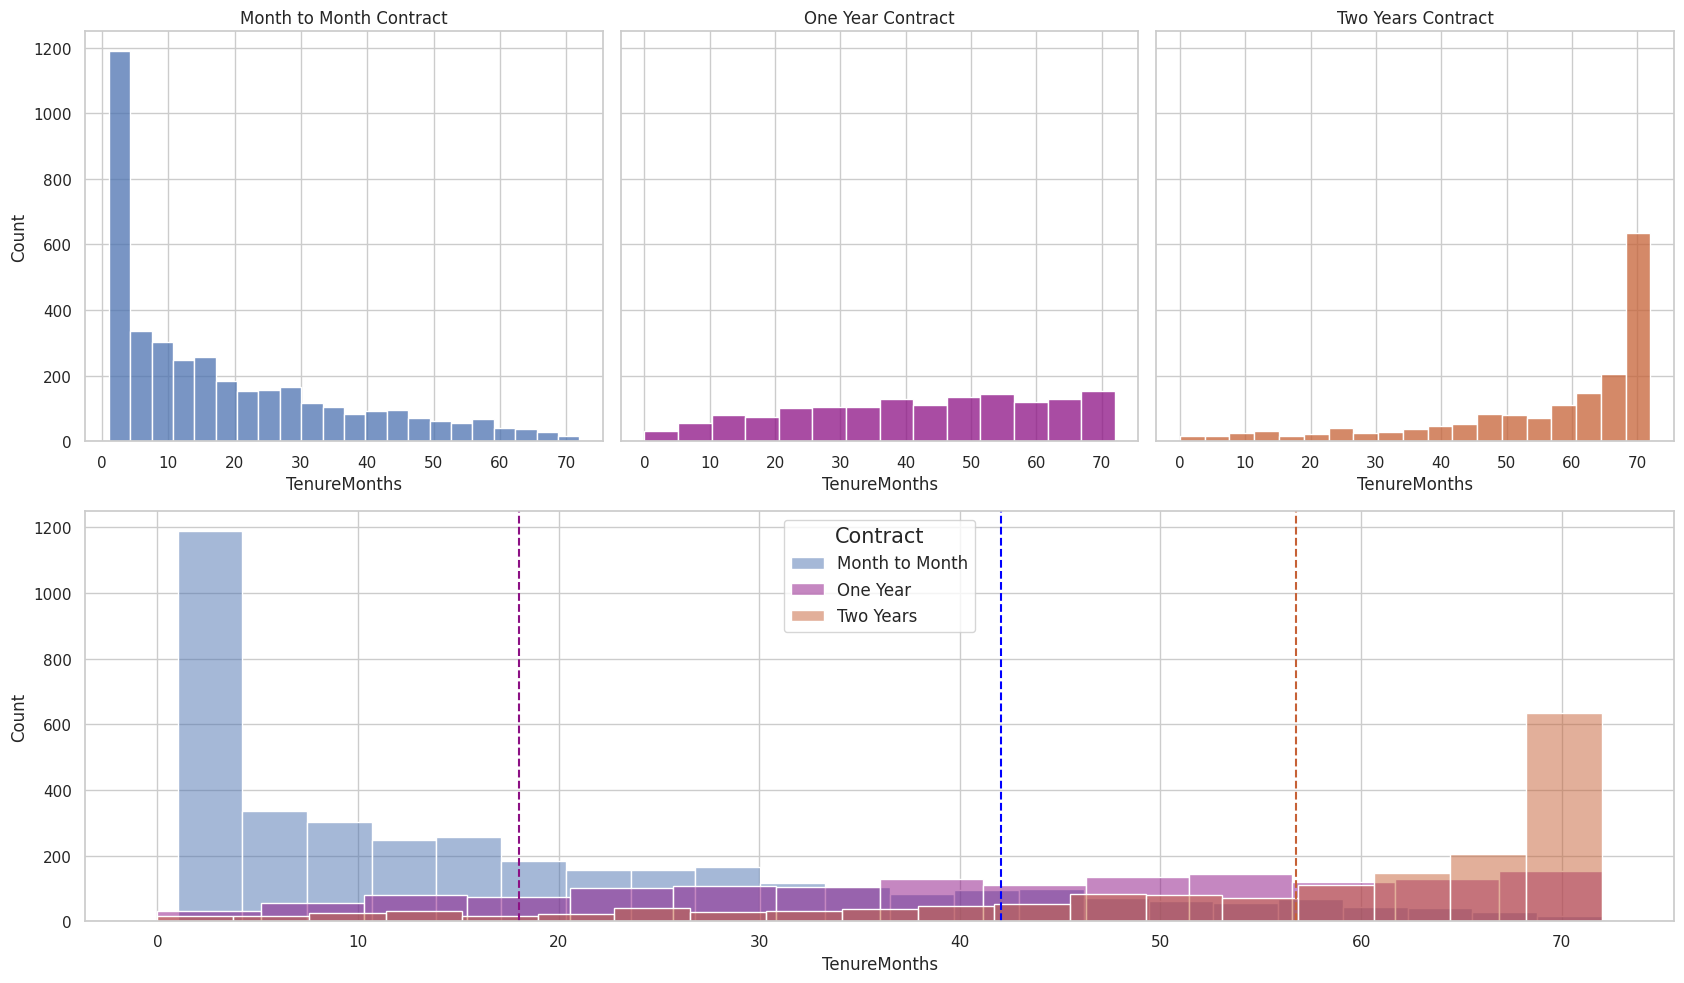

In [ ]:
# Criar a figura e os eixos
fig, axes = plt.subplots(2, 3, figsize=(17, 10), sharey=True)
gs = axes[0, 1].get_gridspec()

# Remover os eixos da segunda linha
for ax in axes[1, :3]:
    ax.remove()

# Adicionar um eixo grande
axbig = fig.add_subplot(gs[1, :3])

# Criar os histogramas para diferentes tipos de contrato
sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'Month-to-month'], ax=axes[0, 0])
axes[0, 0].set_title('Month to Month Contract')

sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'One year'], ax=axes[0, 1], color="#8C1084")
axes[0, 1].set_title('One Year Contract')

sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'Two year'], ax=axes[0, 2], color="#C66136")
axes[0, 2].set_title('Two Years Contract')

# Calcular as médias de tenure para cada tipo de contrato
MtM_mean = df_telco[df_telco['Contract'] == 'Month-to-month']['TenureMonths'].mean()
OY_mean = df_telco[df_telco['Contract'] == 'One year']['TenureMonths'].mean()
TY_mean = df_telco[df_telco['Contract'] == 'Two year']['TenureMonths'].mean()

# Criar o histograma combinado nos eixos grandes
sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'Month-to-month'], ax=axbig, alpha=0.5, label='Month to Month')
sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'One year'], ax=axbig, color="#8C1084", alpha=0.5, label='One Year')
sns.histplot(x='TenureMonths', data=df_telco[df_telco['Contract'] == 'Two year'], ax=axbig, color="#C66136", alpha=0.5, label='Two Years')

# Adicionar legenda
axbig.legend(loc='upper center', fontsize=12, title="Contract", title_fontsize=15)

# Adicionar linhas verticais para as médias
plt.axvline(x=MtM_mean, color="#8C1084", linestyle='--')
plt.axvline(x=OY_mean, color='blue', linestyle='--')
plt.axvline(x=TY_mean, color="#C66136", linestyle='--')


# Mostrar o gráfico
plt.tight_layout()
plt.show()

Clientes que compram um contrato mensal tendem a permanecer menos como clientes, enquanto clientes que contratam a empresa por dois anos tendem a permanecer mais tempo;
INTERPRETAÇÃO: Cada linha vertical representa a média da distribuição;

# Total Services x MonthlyCharge

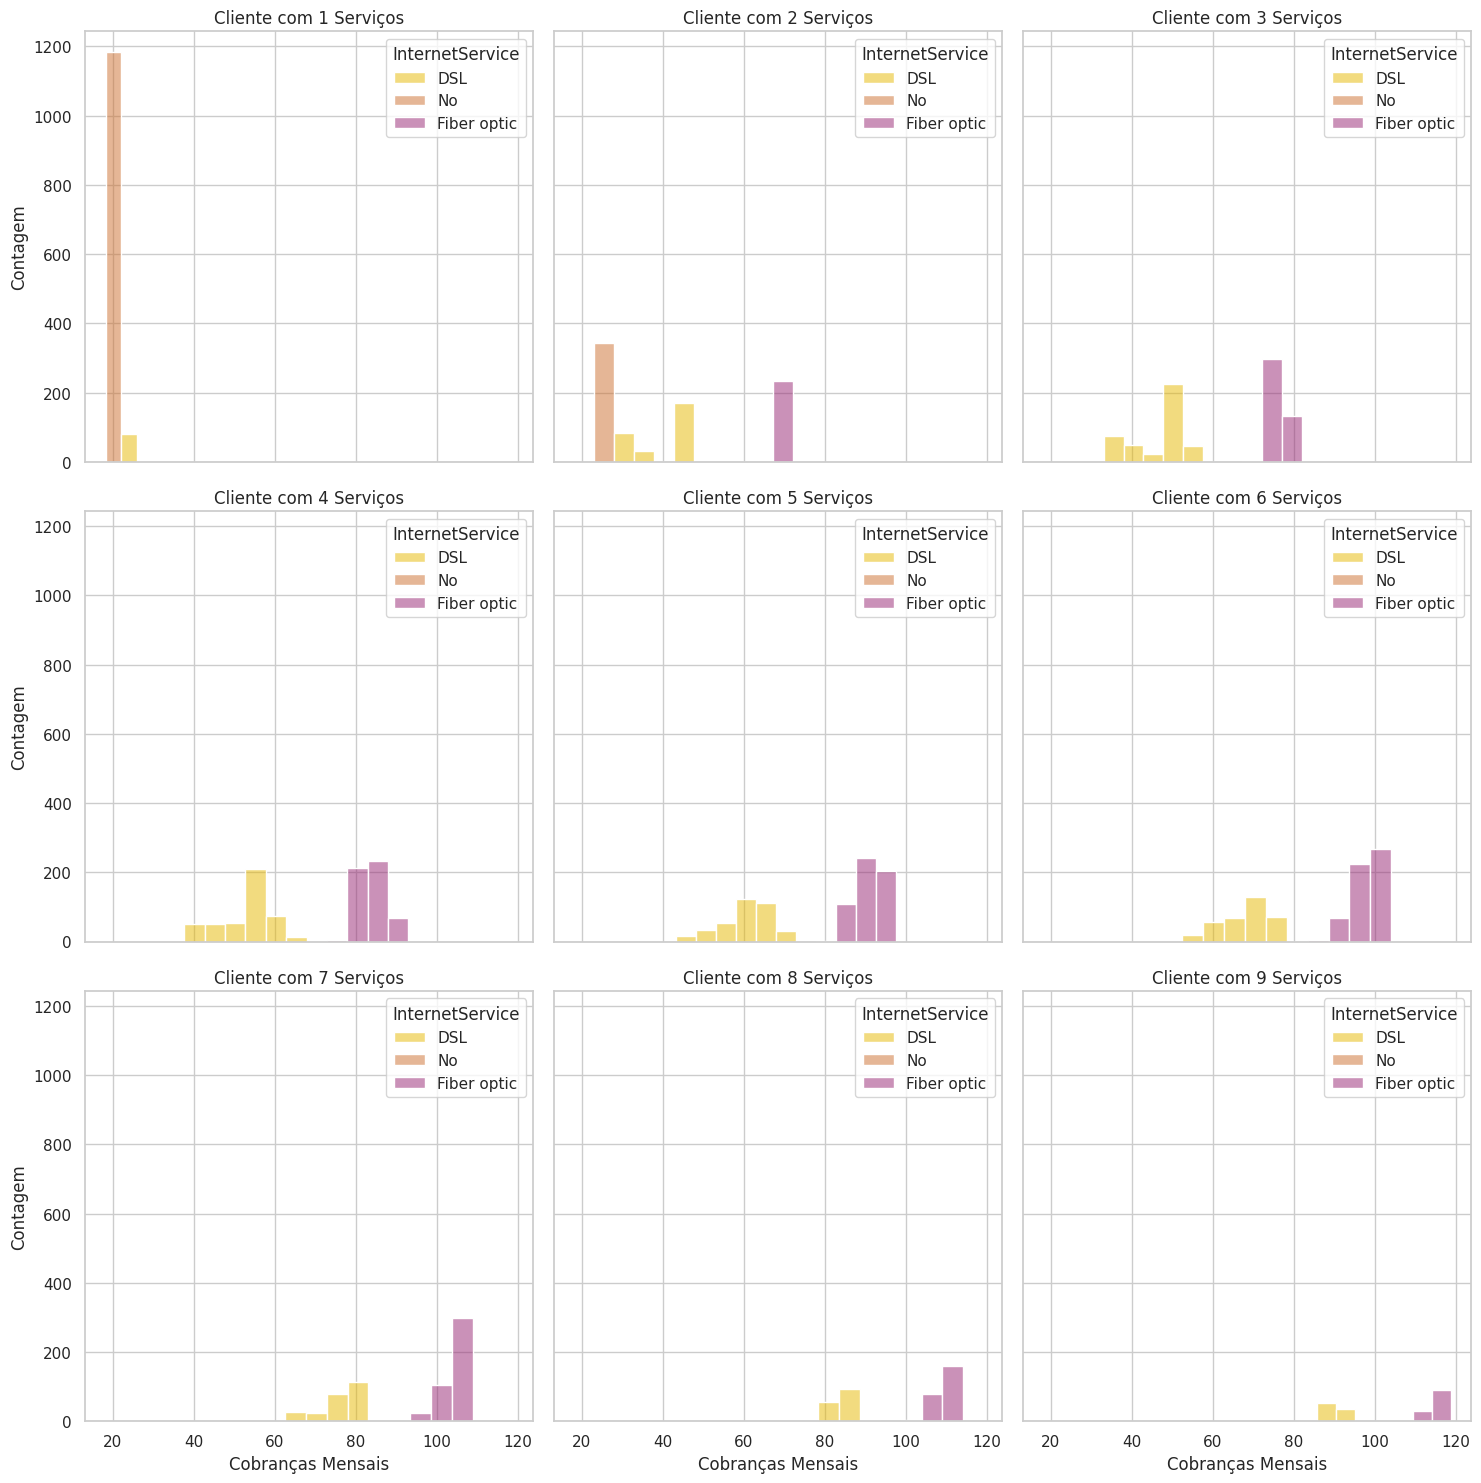

In [ ]:
# Definir a paleta de cores
sns.set_palette(sns.color_palette(["#E6B800", "#CC6F2E", "#972573"]))
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

i = 1

for row in range(3):
    for column in range(3):
        sns.histplot(data=df_telco[df_telco['total_services'] == i], x='MonthlyCharges',
                     ax=axes[row, column], binwidth=5,
                     hue='InternetService', hue_order=['DSL','No','Fiber optic'])

        # Definir título, rótulo do eixo X e rótulo do eixo Y
        axes[row, column].set_title('Cliente com {} Serviços'.format(i))
        axes[row, column].set_xlabel('Cobranças Mensais')  # Tradução do rótulo do eixo X
        axes[row, column].set_ylabel('Contagem')         # Tradução do rótulo do eixo Y

        i += 1

# Adicionar legenda
handles, labels = axes[0, 0].get_legend_handles_labels()

# Ajustar layout
plt.tight_layout()
plt.show()

Existe correlação entre MonthlyCharges e Total_Services, quanto mais serviços um cliente compra, mais ele paga;

Clientes que compram "fibra óptica" tendem a pagar mais que os demais clientes (mensalmente), independentemente do valor dos serviços;

# Total Services x Total Charges

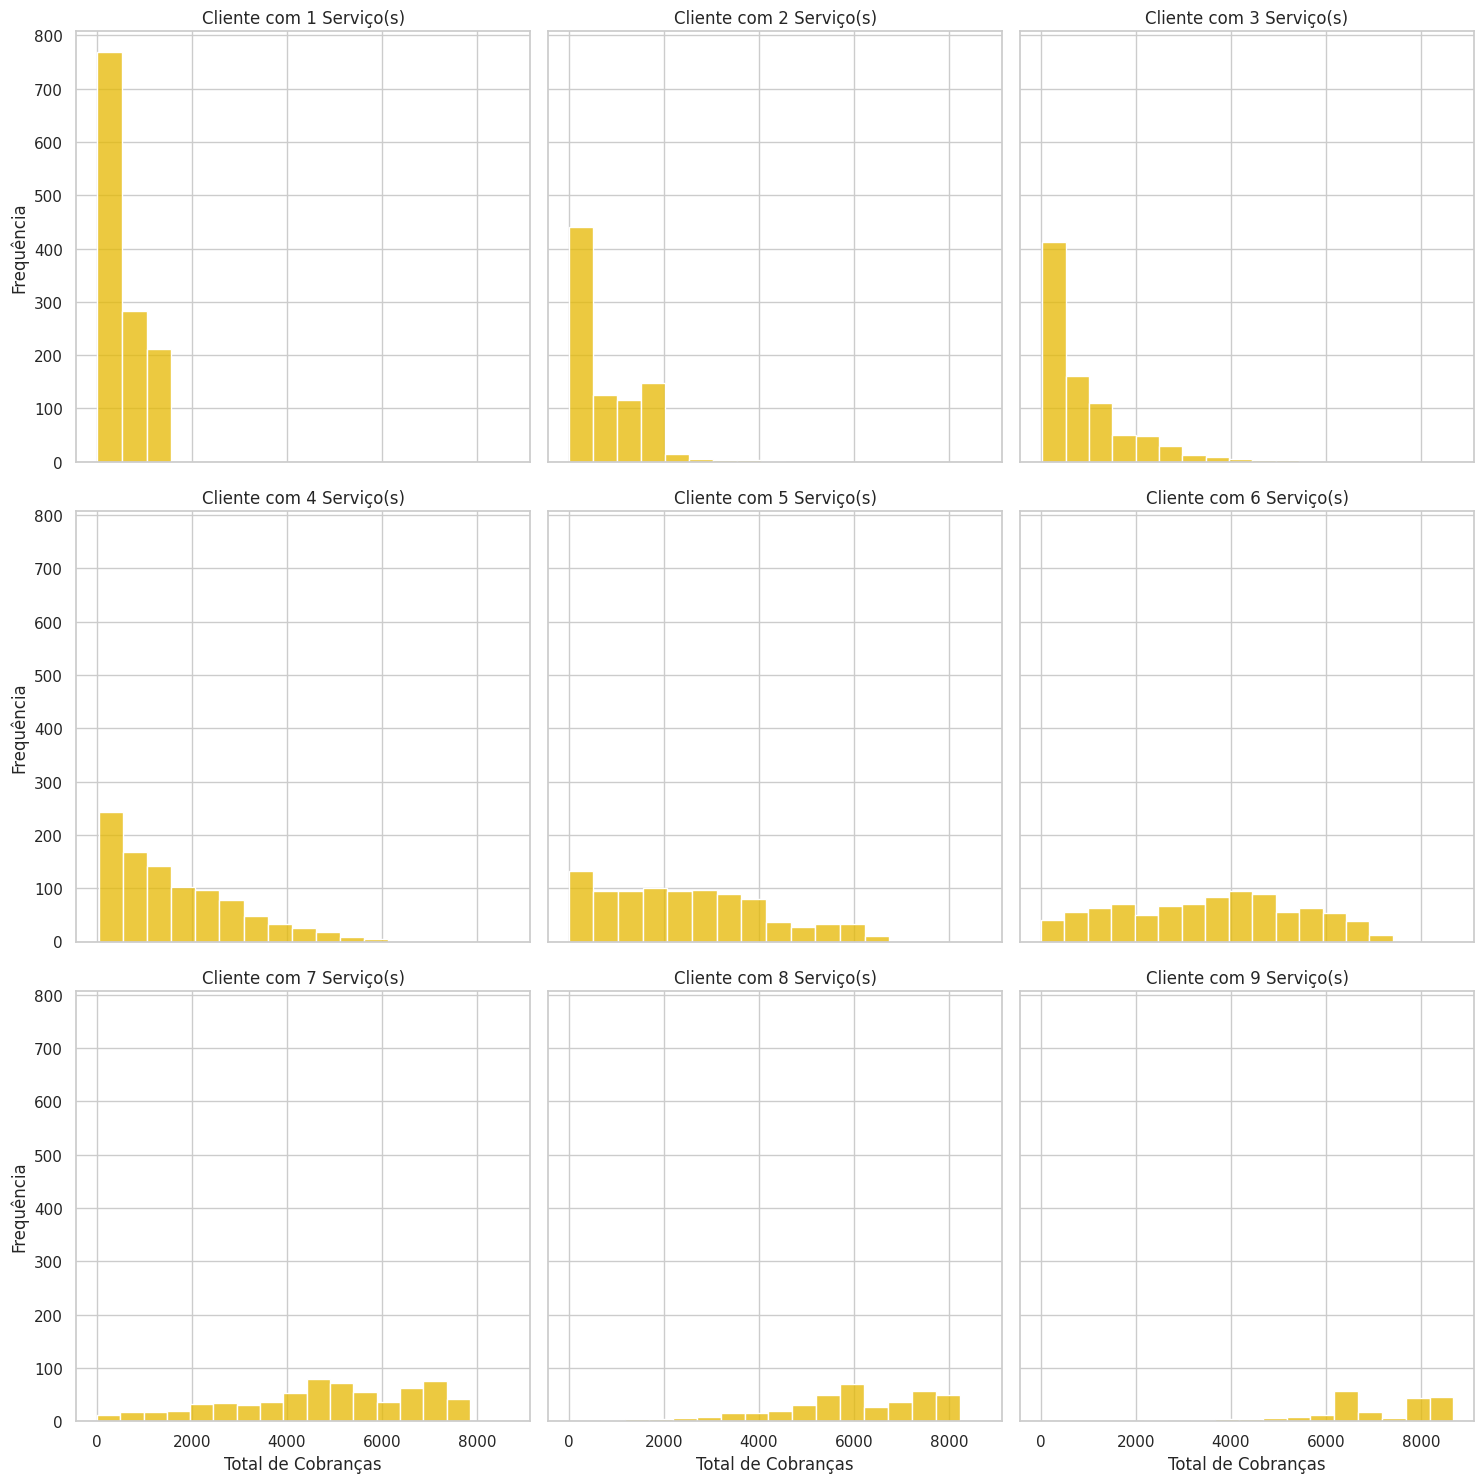

In [ ]:
# Definir a paleta de cores
sns.set_palette(sns.color_palette(["#E6B800", "#972573"]))
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

i = 1

for row in range(3):
    for column in range(3):
        sns.histplot(data=df_telco[df_telco['total_services'] == i], x='TotalCharges',
                     ax=axes[row, column], binwidth=500)

        # Definir título, rótulo do eixo X e rótulo do eixo Y
        axes[row, column].set_title('Cliente com {} Serviço(s)'.format(i))  # Título traduzido
        axes[row, column].set_xlabel('Total de Cobranças')  # Rótulo do eixo X traduzido
        axes[row, column].set_ylabel('Frequência')          # Rótulo do eixo Y traduzido

        i += 1

# Ajustar layout
plt.tight_layout()
plt.show()

Observa-se uma concentração em tarifas menores quando o total de serviços é baixo (menor que 3), e tarifas maiores quando o total de serviços também é alto (9), mas os valores intermediários apresentam uma ampla variação quando comparados ao pagamento mensal

# Relação de rotatividade com TotalCharges e MonthlyCharges

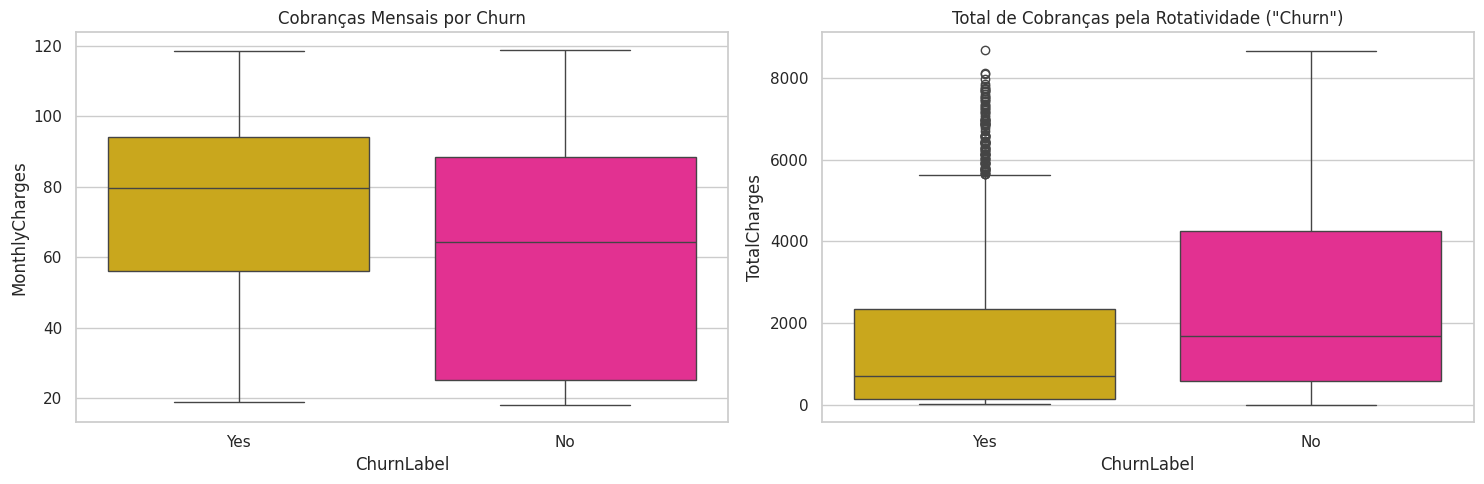

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Definir a paleta de cores
palette = {'Yes': '#E6B800', 'No': 'deeppink'}

# Gráfico de caixa para MonthlyCharges
sns.boxplot(data=df_telco, y='MonthlyCharges', x='ChurnLabel', ax=axes[0], palette=palette)
axes[0].set_title('Cobranças Mensais por Churn')

# Gráfico de caixa para TotalCharges
sns.boxplot(data=df_telco, y='TotalCharges', x='ChurnLabel', ax=axes[1], palette=palette)
axes[1].set_title('Total de Cobranças pela Rotatividade ("Churn")')

# Ajustar layout
plt.tight_layout()
plt.show()

A ocorrência de Churn é mais frequente nos valores altos de MonthlyCharges, mas ainda assim, é bem distribuído, pois não há outliers
já a ocorrência de Churn quando analisada sob a ótica de TotalCharges ocorre mais frequentemente em valores baixos com outliers superiores

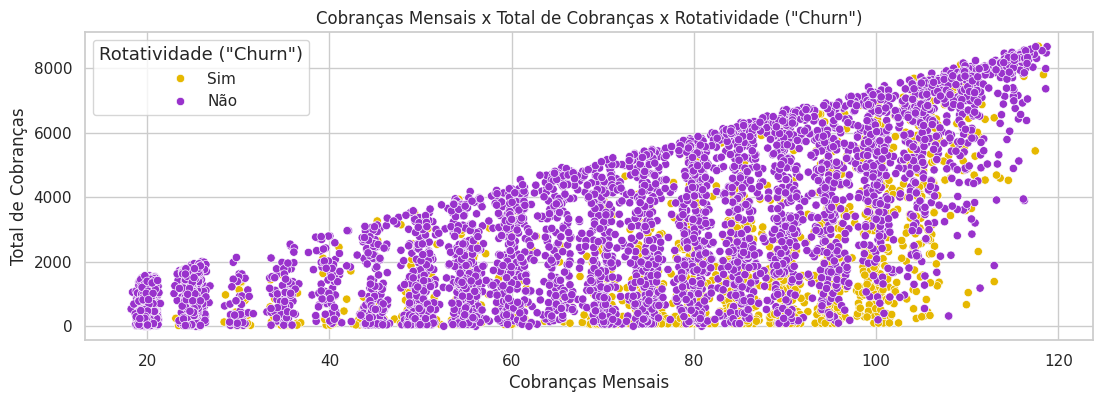

In [ ]:
plt.figure(figsize=(13, 4))

sns.scatterplot(data=df_telco, x='MonthlyCharges', y='TotalCharges', hue='ChurnLabel', palette = {'Yes': '#E6B800', 'No': 'darkorchid'})

# Adicionar título e rótulos
plt.title('Cobranças Mensais x Total de Cobranças x Rotatividade ("Churn")')
plt.xlabel('Cobranças Mensais')
plt.ylabel('Total de Cobranças')
# Traduzir a legenda
handles, labels = plt.gca().get_legend_handles_labels()
translated_labels = ['Não' if label == 'No' else 'Sim' for label in labels]
plt.legend(handles, translated_labels, title='Rotatividade ("Churn")', title_fontsize='13', fontsize='11')
# Mostrar o gráfico
plt.show()

Quanto menos tempo mais chance da ocorrência de churn

In [ ]:
## Removendo váriaveis que contem informações irrelevantes, como ChurnReason
df_telco.drop(['ChurnReason', 'City' ], axis=1, inplace =True)

# Criando uma nova base a partir do Data frame df_telco para padronizar e normalizar as variaveis categoricas

In [ ]:
#Verificando variaveis e atributos
df_dumy = df_telco.copy()
df_dumy.nunique()

Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
TenureMonths          73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
ChurnLabel             2
total_services         9
dtype: int64

Encoding Label das Variaveis

In [ ]:
# Encoding da Coluna 'InternetService' - aplicar variáveis dummy
internetservice = pd.get_dummies(df_dumy['InternetService'], prefix='InternetService').drop('InternetService_No', axis=1)

# Exibir as primeiras linhas do DataFrame resultante
internetservice.head()

InternetService_DSL  InternetService_Fiber optic
0                 True                        False
1                False                         True
2                False                         True
3                False                         True
4                False                         True

In [ ]:
# Criar variáveis dummies para outras colunas e concatenar
for i in ['DeviceProtection', 'TechSupport', 'OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']:
    internetservice = pd.concat([
        internetservice,
        pd.get_dummies(df_dumy[i], prefix=i).drop('{}_No internet service'.format(i), axis=1) # Alterado ' ' para '_' no método drop.
    ], axis=1)

# Exibir as primeiras linhas do DataFrame resultante
internetservice.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
0                 True                        False                 True   
1                False                         True                 True   
2                False                         True                False   
3                False                         True                False   
4                False                         True                False   

   DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  OnlineSecurity_No  \
0                 False            True            False              False   
1                 False            True            False               True   
2                  True            True            False               True   
3                  True           False             True               True   
4                  True            True            False               True   

   OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_Yes  StreamingTV_No  \
0                True            False              True            True   
1               False             True             False            True   
2               False             True             False           False   
3               False             True             False           False   
4               False            False              True           False   

   StreamingTV_Yes  StreamingMovies_No  StreamingMovies_Yes  
0            False                True                False  
1            False                True                False  
2             True               False                 True  
3             True               False                 True  
4             True               False                 True

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=internetservice)

https://docs.google.com/spreadsheets/d/1f15PKosqXojKqIQd_yx0ZsMmlPxvMLiY5hs7DfERnK4#gid=0


In [ ]:
# Criar variáveis dummies para outras colunas e concatenar
for i in ['Gender', 'SeniorCitizen','Partner', 'Dependents', 'PhoneService', 'Contract', 'PaperlessBilling', 'PaymentMethod']:
    internetservice = pd.concat([internetservice, pd.get_dummies(df_dumy[i], prefix=i, drop_first=True)], axis=1)

# Exibir as primeiras linhas do DataFrame resultante
internetservice.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
0                 True                        False                 True   
1                False                         True                 True   
2                False                         True                False   
3                False                         True                False   
4                False                         True                False   

   DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  OnlineSecurity_No  \
0                 False            True            False              False   
1                 False            True            False               True   
2                  True            True            False               True   
3                  True           False             True               True   
4                  True            True            False               True   

   OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_Yes  ...  \
0                True            False              True  ...   
1               False             True             False  ...   
2               False             True             False  ...   
3               False             True             False  ...   
4               False            False              True  ...   

   SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0              False        False           False              True   
1              False        False            True              True   
2              False        False            True              True   
3              False         True            True              True   
4              False        False            True              True   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0              False              False                  True   
1              False              False                  True   
2              False              False                  True   
3              False              False                  True   
4              False              False                  True   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                           False   
1                                  False                            True   
2                                  False                            True   
3                                  False                            True   
4                                  False                           False   

   PaymentMethod_Mailed check  
0                        True  
1                       False  
2                       False  
3                       False  
4                       False  

[5 rows x 25 columns]

In [ ]:
# Criar variáveis fictícias para a coluna 'MultipleLines' e concatenar
internetservice = pd.concat([
    internetservice,
    pd.get_dummies(df_dumy['MultipleLines'], prefix='MultiLines').drop('MultiLines_No phone service', axis=1)
], axis=1)

# Exibir as primeiras linhas do DataFrame resultante
internetservice.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
0                 True                        False                 True   
1                False                         True                 True   
2                False                         True                False   
3                False                         True                False   
4                False                         True                False   

   DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  OnlineSecurity_No  \
0                 False            True            False              False   
1                 False            True            False               True   
2                  True            True            False               True   
3                  True           False             True               True   
4                  True            True            False               True   

   OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_Yes  ...  Dependents_Yes  \
0                True            False              True  ...           False   
1               False             True             False  ...            True   
2               False             True             False  ...            True   
3               False             True             False  ...            True   
4               False            False              True  ...            True   

   PhoneService_Yes  Contract_One year  Contract_Two year  \
0              True              False              False   
1              True              False              False   
2              True              False              False   
3              True              False              False   
4              True              False              False   

   PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                  True                                  False   
1                  True                                  False   
2                  True                                  False   
3                  True                                  False   
4                  True                                  False   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  MultiLines_No  \
0                           False                        True           True   
1                            True                       False           True   
2                            True                       False          False   
3                            True                       False          False   
4                           False                       False          False   

   MultiLines_Yes  
0           False  
1           False  
2            True  
3            True  
4            True  

[5 rows x 27 columns]

In [ ]:
# Encoding Variavel Churn
df_dumy['ChurnLabel'] = df_dumy['ChurnLabel'].map({'Yes':1,'No':0})

In [ ]:
internetservice = pd.concat([internetservice,df_dumy[['TenureMonths','MonthlyCharges','TotalCharges','ChurnLabel']]],axis=1)
internetservice.columns

Index(['InternetService_DSL', 'InternetService_Fiber optic',
       'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_Yes', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'MultiLines_No', 'MultiLines_Yes', 'TenureMonths', 'MonthlyCharges',
       'TotalCharges', 'ChurnLabel'],
      dtype='object')

# Análisando a nova Base

In [ ]:
df_unbalanced = internetservice
df_unbalanced.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
0                 True                        False                 True   
1                False                         True                 True   
2                False                         True                False   
3                False                         True                False   
4                False                         True                False   

   DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  OnlineSecurity_No  \
0                 False            True            False              False   
1                 False            True            False               True   
2                  True            True            False               True   
3                  True           False             True               True   
4                  True            True            False               True   

   OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_Yes  ...  \
0                True            False              True  ...   
1               False             True             False  ...   
2               False             True             False  ...   
3               False             True             False  ...   
4               False            False              True  ...   

   PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                  True                                  False   
1                  True                                  False   
2                  True                                  False   
3                  True                                  False   
4                  True                                  False   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  MultiLines_No  \
0                           False                        True           True   
1                            True                       False           True   
2                            True                       False          False   
3                            True                       False          False   
4                           False                       False          False   

   MultiLines_Yes  TenureMonths  MonthlyCharges  TotalCharges  ChurnLabel  
0           False             2           53.85        108.15           1  
1           False             2           70.70        151.65           1  
2            True             8           99.65        820.50           1  
3            True            28          104.80       3046.05           1  
4            True            49          103.70       5036.30           1  

[5 rows x 31 columns]

In [ ]:
df_unbalanced.shape

(7043, 31)

In [ ]:
df_unbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   InternetService_DSL                    7043 non-null   bool   
 1   InternetService_Fiber optic            7043 non-null   bool   
 2   DeviceProtection_No                    7043 non-null   bool   
 3   DeviceProtection_Yes                   7043 non-null   bool   
 4   TechSupport_No                         7043 non-null   bool   
 5   TechSupport_Yes                        7043 non-null   bool   
 6   OnlineSecurity_No                      7043 non-null   bool   
 7   OnlineSecurity_Yes                     7043 non-null   bool   
 8   OnlineBackup_No                        7043 non-null   bool   
 9   OnlineBackup_Yes                       7043 non-null   bool   
 10  StreamingTV_No                         7043 non-null   bool   
 11  Stre

In [ ]:
# embaralhar os dados
df_unbalanced = df_unbalanced.reindex(np.random.permutation(df_unbalanced.index))

# separar a classe-alvo das classes independentes
# Separando X e y
X = df_unbalanced.drop('ChurnLabel', axis=1)
y = df_unbalanced['ChurnLabel']

# verificar tamanho das variáveis
print(f'As variáveis independentes estão em X: {X.shape[0]} registros, { X.shape[1]} atributos')
print(f'A variável alvo "Churn" está em y: {y.shape[0]} registros.')

As variáveis independentes estão em X: 7043 registros, 30 atributos
A variável alvo "Churn" está em y: 7043 registros.


Separar a base de treino e teste para treinar os modelos

In [ ]:
# Separando a base de treino e tese

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, shuffle=True, random_state=42)

# Verificando tamanho dos conjuntos
print(f'O conjunto de treino tem {X_train.shape[0]} registros.')
print(f'O conjunto de testes tem {X_test.shape[0]} registros.')

O conjunto de treino tem 4930 registros.
O conjunto de testes tem 2113 registros.


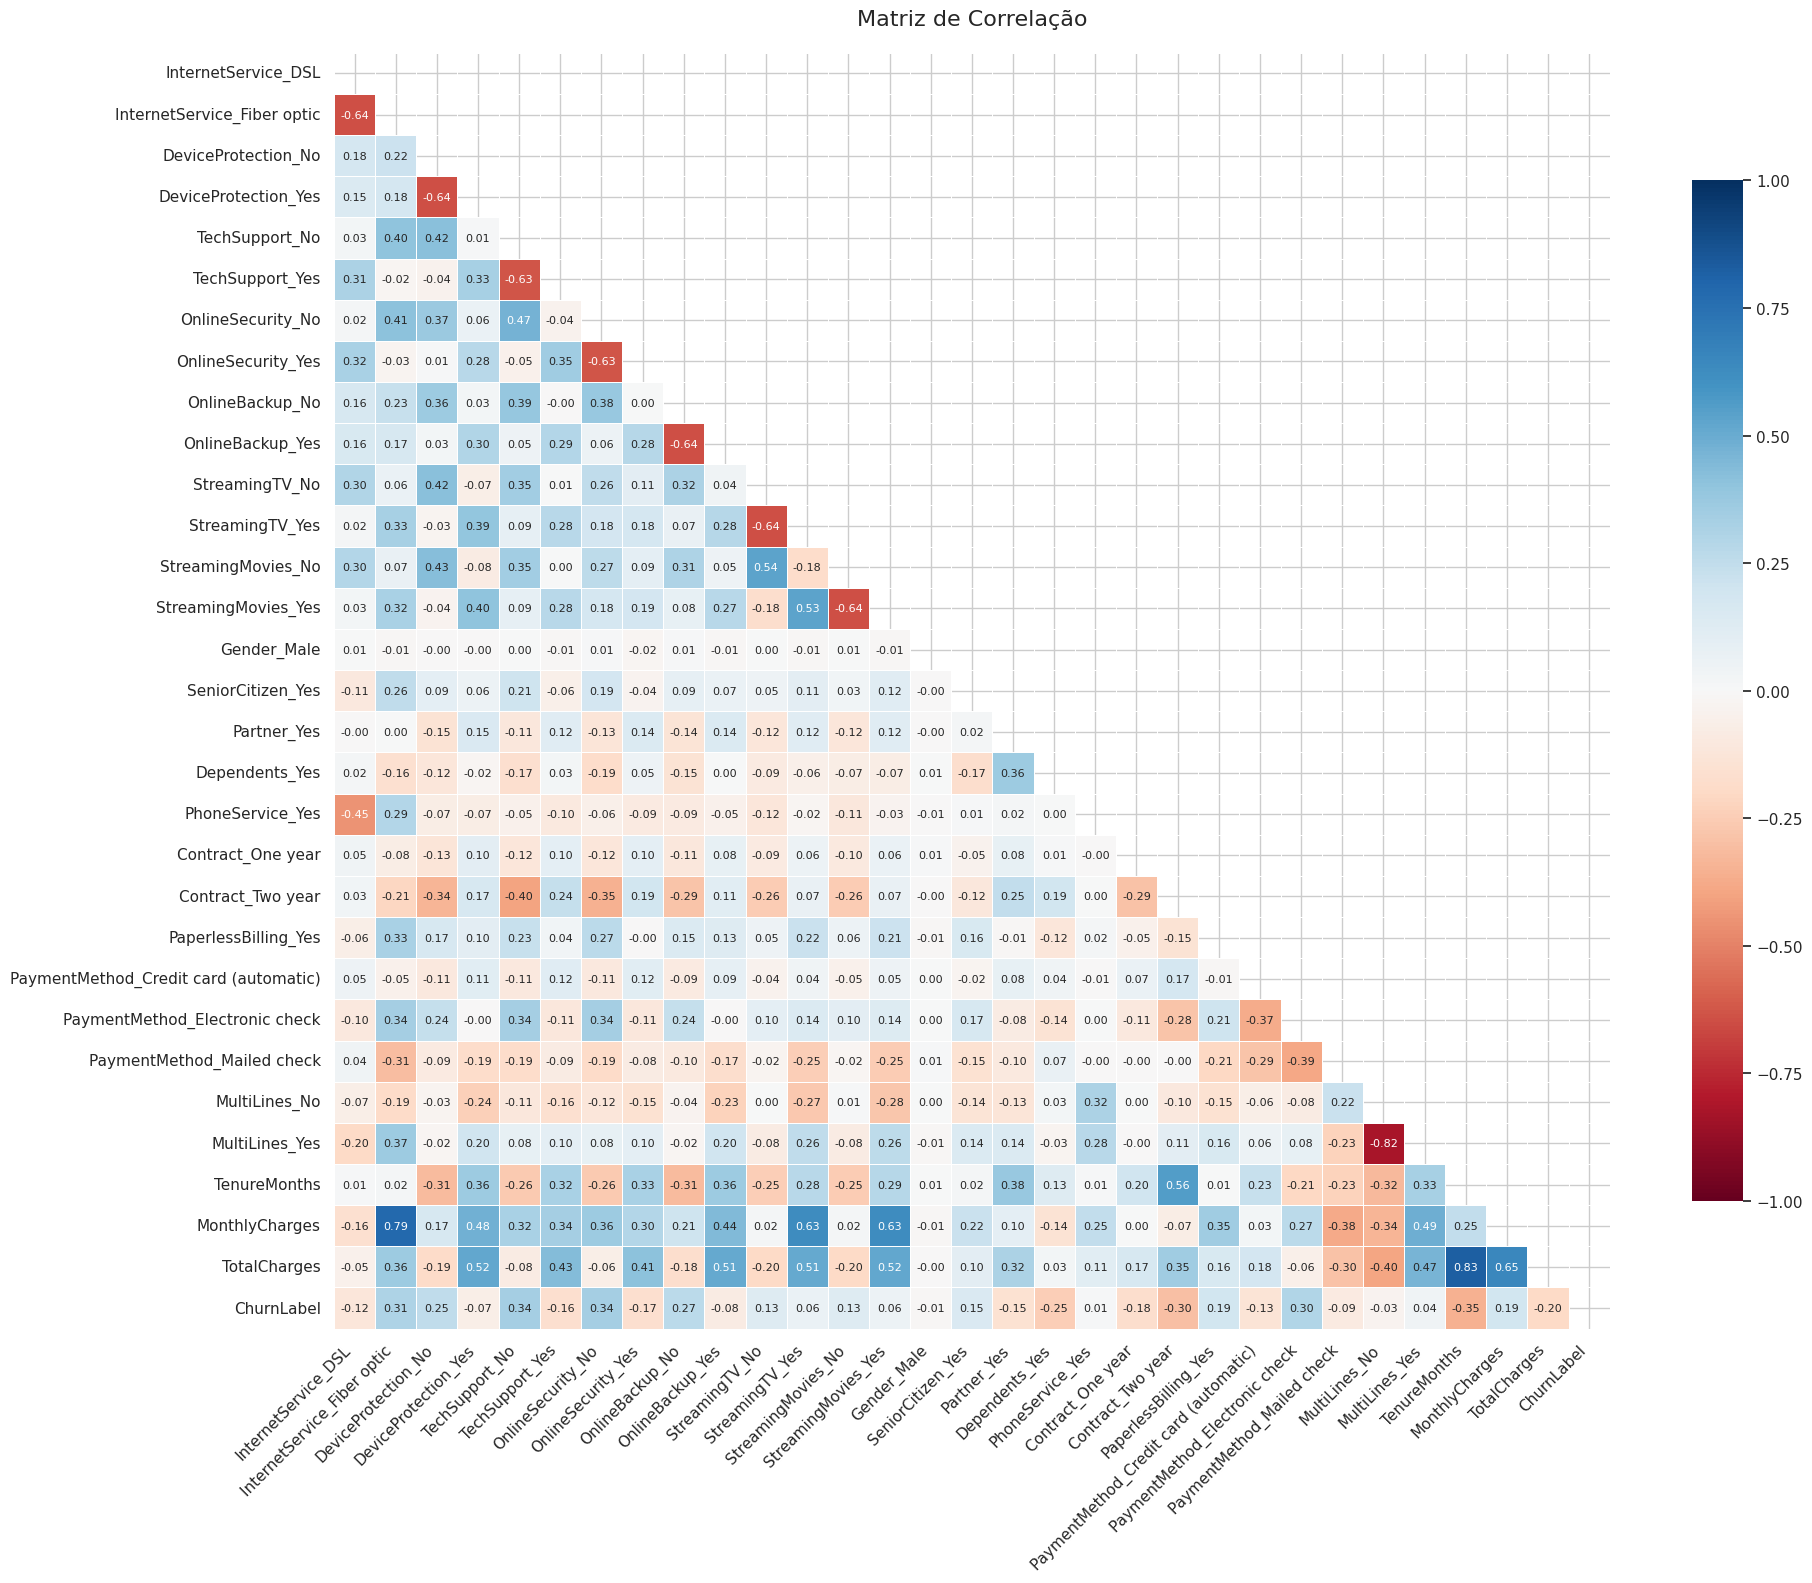

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcular a matriz de correlação
corr_matrix = df_unbalanced.corr()

# Criar uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurar o tamanho da figura (ajuste conforme necessário)
plt.figure(figsize=(20, 16))

# Criar o heatmap
sns.heatmap(corr_matrix,
            mask=mask,
            cmap="RdBu",
            vmin=-1, vmax=1,
            center=0,
            annot=True,
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            annot_kws={"size": 8})  # Reduzir o tamanho da fonte das anotações

# Ajustar os rótulos
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajustar o título e os limites do gráfico
plt.title("Matriz de Correlação", fontsize=16, pad=20)
plt.tight_layout()

# Exibir o gráfico
plt.show()

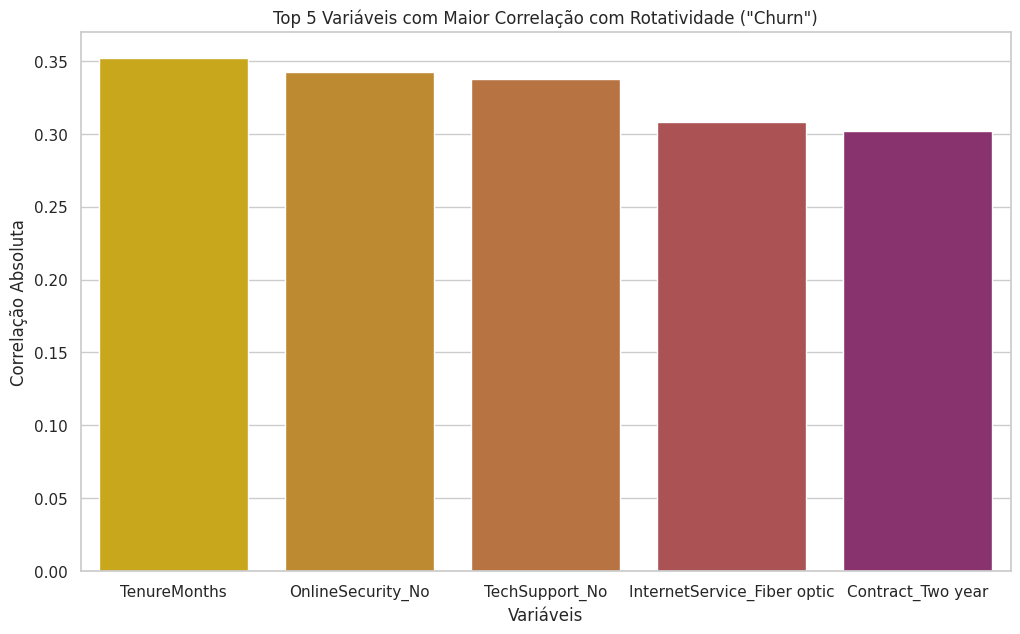

In [ ]:
# Calcular as correlações e selecionar as 5 mais altas (excluindo 'Churn')
top_corr = abs(df_unbalanced.corr()['ChurnLabel']).sort_values(ascending=False)[1:6]

# gráfico de barras
plt.figure(figsize=(12, 7))
sns.barplot(y=top_corr.values, x=top_corr.index, palette=sns.color_palette([
    "#E6B800", "#D69019", "#CC6F2E", "#B84446", "#972573"
]))

# Adicionar título e rótulos
plt.title('Top 5 Variáveis com Maior Correlação com Rotatividade ("Churn")')
plt.xlabel('Variáveis')
plt.ylabel('Correlação Absoluta')

# Mostrar o gráfico
plt.show()

In [ ]:
# Calcular as correlações e selecionar as 10 menores (excluindo 'Churn')
tail_corr = abs(df_unbalanced.corr()['ChurnLabel']).sort_values(ascending=False)[-10:]

# Exibir os resultados
print(tail_corr)

InternetService_DSL           0.124214
PaymentMethod_Mailed check    0.091683
OnlineBackup_Yes              0.082255
DeviceProtection_Yes          0.066160
StreamingTV_Yes               0.063228
StreamingMovies_Yes           0.061382
MultiLines_Yes                0.040102
MultiLines_No                 0.032569
PhoneService_Yes              0.011942
Gender_Male                   0.008612
Name: ChurnLabel, dtype: float64


In [ ]:
# Importação de bibliotecas
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Inicializar o StandardScaler
sc = StandardScaler()

# Normalizar as colunas 'TenureMonths', 'MonthlyCharges', 'TotalCharges'
X_train[['TenureMonths', 'MonthlyCharges', 'TotalCharges']] = sc.fit_transform(X_train[['TenureMonths', 'MonthlyCharges', 'TotalCharges']])

# Exibir as primeiras linhas do DataFrame resultante
X_train.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
2776                False                         True                 True   
597                 False                         True                 True   
747                 False                         True                 True   
3320                False                         True                False   
1718                False                         True                 True   

      DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  \
2776                 False            True            False   
597                  False           False             True   
747                  False            True            False   
3320                  True            True            False   
1718                 False            True            False   

      OnlineSecurity_No  OnlineSecurity_Yes  OnlineBackup_No  \
2776              False                True             True   
597               False                True             True   
747                True               False             True   
3320              False                True             True   
1718               True               False             True   

      OnlineBackup_Yes  ...  Contract_Two year  PaperlessBilling_Yes  \
2776             False  ...              False                  True   
597              False  ...              False                  True   
747              False  ...              False                  True   
3320             False  ...              False                  True   
1718             False  ...              False                  True   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
2776                                  False                           False   
597                                   False                            True   
747                                   False                            True   
3320                                   True                           False   
1718                                  False                            True   

      PaymentMethod_Mailed check  MultiLines_No  MultiLines_Yes  TenureMonths  \
2776                        True          False            True      0.684054   
597                        False           True           False     -0.379751   
747                        False          False            True     -0.747992   
3320                       False           True           False     -0.379751   
1718                       False          False            True      0.397645   

      MonthlyCharges  TotalCharges  
2776        1.202605      1.137451  
597         1.169321      0.023530  
747         0.711674     -0.461587  
3320        1.172650      0.006463  
1718        0.981270      0.844787  

[5 rows x 30 columns]

In [ ]:
X_test[['TenureMonths', 'MonthlyCharges', 'TotalCharges']] = sc.fit_transform(X_test[['TenureMonths', 'MonthlyCharges', 'TotalCharges']])

# Exibir as primeiras linhas do DataFrame resultante
X_test.head()

InternetService_DSL  InternetService_Fiber optic  DeviceProtection_No  \
465                 False                        False                False   
4766                False                        False                False   
781                 False                         True                 True   
6006                False                         True                False   
2390                 True                        False                False   

      DeviceProtection_Yes  TechSupport_No  TechSupport_Yes  \
465                  False           False            False   
4766                 False           False            False   
781                  False           False             True   
6006                  True            True            False   
2390                  True           False             True   

      OnlineSecurity_No  OnlineSecurity_Yes  OnlineBackup_No  \
465               False               False            False   
4766              False               False            False   
781                True               False             True   
6006               True               False            False   
2390               True               False            False   

      OnlineBackup_Yes  ...  Contract_Two year  PaperlessBilling_Yes  \
465              False  ...              False                 False   
4766             False  ...               True                 False   
781              False  ...              False                  True   
6006              True  ...               True                  True   
2390              True  ...               True                  True   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
465                                   False                           False   
4766                                   True                           False   
781                                   False                            True   
6006                                  False                           False   
2390                                  False                           False   

      PaymentMethod_Mailed check  MultiLines_No  MultiLines_Yes  TenureMonths  \
465                         True           True           False     -1.151161   
4766                       False           True           False      1.507160   
781                        False          False            True     -0.224777   
6006                       False          False            True      1.587715   
2390                       False          False            True      1.587715   

      MonthlyCharges  TotalCharges  
465        -1.474583     -0.965414  
4766       -1.491147     -0.417985  
781         0.484830     -0.045024  
6006        1.322922      2.269922  
2390        0.671993      1.764923  

[5 rows x 30 columns]

# Treinando o modelo com Base desbalanceada negrito

In [ ]:
from sklearn.linear_model import LogisticRegression

lg_reg_unbalanced = LogisticRegression(random_state=42)

# Criando uma lista de mátricas do Modelo Logistic Regression
logistic_regression = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(lg_reg_unbalanced, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Logistic Regression
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  logistic_regression.append(k_result[i].mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_unbalanced = RandomForestClassifier(random_state=42)

# Criando uma lista de métricas do Modelo Random Forest
random_forest = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross validating do modelo
k_result = cross_validate(rf_clf_unbalanced, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Random Forest
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  random_forest.append(k_result[i].mean())

In [ ]:
from xgboost import XGBClassifier

xgb_clf_unbalanced = XGBClassifier(random_state=42)

# Criando uma lista de métricas do Modelo XGBoost
XGBoost = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(xgb_clf_unbalanced, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo XGBoost
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  XGBoost.append(k_result[i].mean())

In [ ]:
#Criando métricas para análise:
metricas = (pd.DataFrame([logistic_regression,random_forest,XGBoost],
                        index=['Logistic Regression','Random Forest','XG Boost'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metricas

Accuracy  Precision  Recall  F1 Score  AUROC
Logistic Regression     80.77      66.06   56.80     61.05  85.67
Random Forest           79.11      63.55   49.85     55.86  83.14
XG Boost                78.05      59.80   53.06     56.18  83.46

Insight: Considerando o problema de negócio, identificar probabilidade de um cliente deixar o serviço (TP - True Positives) e minimizar os casos de erros identificados como sem probabilidade de sair, o ideial seria analisar a métrica Recall pra identificação do melhor modelo para esse caso

# Pesquisa de Hiperparâmetros para melhoria de desempenho dos *modelo*

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_XGBClassifier_unbalanced = XGBClassifier(random_state = 42)

# Parameters
params_XGB_unbalanced = {
    'max_depth': [1, 5, 10],
    'learning_rate': [None, 0.01, 0.1],
    'n_estimators': [10, 100, 200],
    'subsample': [0.5, 1]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_XGB_unbalanced = GridSearchCV(estimator=tuned_XGBClassifier_unbalanced,
                 param_grid=params_XGB_unbalanced,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_XGB_unbalanced.fit(X_train, y_train)

# Print score dos melhores paramentros
best_recall_unbalanced = GS_XGB_unbalanced.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_unbalanced*100))

# Print melhores parametros
best_parameters_unbalanced = GS_XGB_unbalanced.best_params_
print("Melhores Parametros:", best_parameters_unbalanced)

Best F1 Score: 57.11 %
Melhores Parametros: {'learning_rate': None, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.5}


In [ ]:
from xgboost import XGBClassifier

xgb_unbalanced_gs = XGBClassifier(learning_rate= None, max_depth= 1, n_estimators=100, subsample=0.5, random_state=42)

# Criando uma lista de métricas do Modelo XGBoost
xgb_desbal_gs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(xgb_unbalanced_gs, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo XGBoost
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  xgb_desbal_gs.append(k_result[i].mean())

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_rf_unbalanced = RandomForestClassifier(random_state=42)

# Parameters
params_rf_unbalanced = {
    'max_depth': [None, 10, 20],
    'n_estimators': [10, 100, 200],
    'min_samples_split': [None, 2, 5, 10]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_rf_unbalanced = GridSearchCV(estimator=tuned_rf_unbalanced,
                 param_grid=params_rf_unbalanced,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_rf_unbalanced.fit(X_train, y_train)

# Print score dos melhores paramentros
best_recall_rf_unbalanced = GS_rf_unbalanced.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_rf_unbalanced*100))

# Print melhores parametros
best_parameters_rf_unbalanced = GS_rf_unbalanced.best_params_
print("Melhores Parametros:", best_parameters_rf_unbalanced)

Best F1 Score: 53.36 %
Melhores Parametros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_unbalanced_gs = RandomForestClassifier(max_depth =10, min_samples_split = 2, n_estimators=100, random_state=42)

# Criando uma lista de métricas do Modelo Random Forest
rf_desbal_gs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(rf_clf_unbalanced_gs, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Random Forest
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  rf_desbal_gs.append(k_result[i].mean())

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_lg_unbalanced = LogisticRegression(random_state=42)

# Parameters
params_lg_unbalanced = {
    'C': [None, 0.1, 1.0],
    'max_iter': [100, 1000],
    'class_weight': ['balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_lg_unbalanced = GridSearchCV(estimator=tuned_lg_unbalanced,
                 param_grid=params_lg_unbalanced,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_lg_unbalanced.fit(X_train, y_train)

# Print score dos melhores paramentros
best_recall_lg_unbalanced = GS_lg_unbalanced.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_lg_unbalanced*100))

# Print melhores parametros
best_parameters_lg_unbalanced = GS_lg_unbalanced.best_params_
print("Melhores Parametros:", best_parameters_lg_unbalanced)

Best F1 Score: 80.35 %
Melhores Parametros: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100}


In [ ]:
from sklearn.linear_model import LogisticRegression

lg_reg_unbalanced_gs = LogisticRegression(C = 1.0, max_iter = 100, class_weight= 'balanced', random_state=42)

# Criando uma lista de mátricas do Modelo Logistic Regression
lg_desbal_gs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(lg_reg_unbalanced_gs, X_train, y_train, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Logistic Regression
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  lg_desbal_gs.append(k_result[i].mean())

In [ ]:
#Criando métricas para análise:
metricas = (pd.DataFrame([lg_desbal_gs,rf_desbal_gs,xgb_desbal_gs],
                        index=['Logistic Regression','Random Forest','XG Boost'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metricas

Accuracy  Precision  Recall  F1 Score  AUROC
Logistic Regression     75.96      53.16   80.35     63.96  85.66
Random Forest           80.32      65.99   53.36     59.00  85.00
XG Boost                80.85      66.15   57.11     61.27  86.04

# Testando com as bases desbalanceadas e hiperparâmetros ajustados

In [ ]:
# Testar o modelo Logistic Regression com os dados desbalanceados
lg_reg_unbalanced_gs.fit(X_train, y_train)

y_predXGB = lg_reg_unbalanced_gs.predict(X_test)

lg_corr_unbal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1552
           1       0.54      0.80      0.64       561

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.78      2113



In [ ]:
# Testar o modelo Random Forest com os dados desbalanceados
rf_clf_unbalanced_gs.fit(X_train, y_train)

y_predXGB = rf_clf_unbalanced_gs.predict(X_test)

rf_corr_unbal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1552
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.81      2113



In [ ]:
# Testar o modelo XGBoost com os dados desbalanceados
xgb_unbalanced_gs.fit(X_train, y_train)

y_predXGB = xgb_unbalanced_gs.predict(X_test)

xgb_corr_unbal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1552
           1       0.68      0.58      0.63       561

    accuracy                           0.82      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.81      0.82      0.81      2113



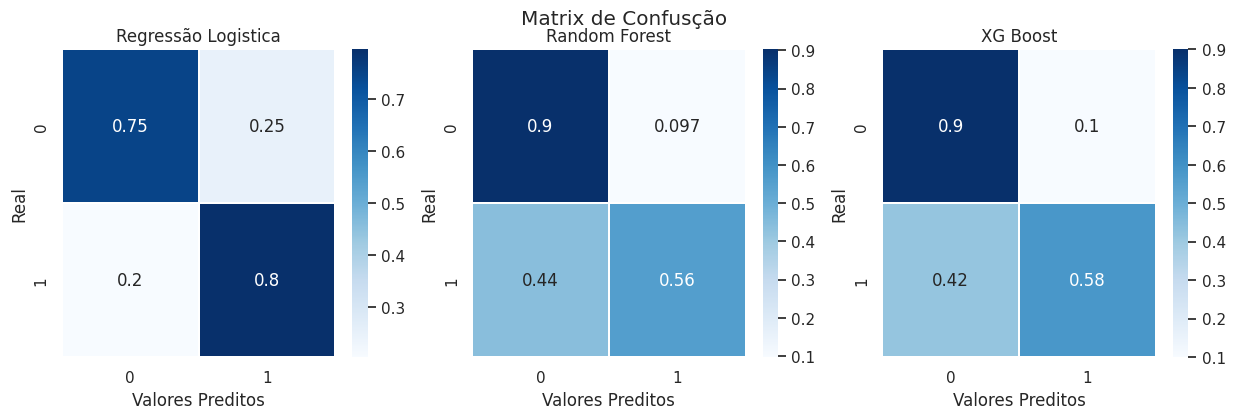

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
fig.suptitle('Matrix de Confusção')

sns.heatmap(lg_corr_unbal, annot=True, linewidths=.1, cmap='Blues', ax=ax[0])
ax[0].set_title('Regressão Logistica')
ax[0].set_ylabel('Real')
ax[0].set_xlabel('Valores Preditos')

sns.heatmap(rf_corr_unbal, annot=True, linewidths=.1, cmap='Blues', ax=ax[1])
ax[1].set_title('Random Forest')
ax[1].set_ylabel('Real')
ax[1].set_xlabel('Valores Preditos')

sns.heatmap(xgb_corr_unbal, annot=True, linewidths=.1, cmap='Blues', ax=ax[2])
ax[2].set_title('XG Boost')
ax[2].set_ylabel('Real')
ax[2].set_xlabel('Valores Preditos')


plt.show()

Regressão Logística:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      3622
           1       0.53      0.79      0.64      1308

    accuracy                           0.76      4930
   macro avg       0.72      0.77      0.73      4930
weighted avg       0.81      0.76      0.77      4930

AUC-ROC: 0.85
Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3622
           1       0.66      0.53      0.59      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.72      0.73      4930
weighted avg       0.79      0.80      0.80      4930

AUC-ROC: 0.85
XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3622
           1       0.66      0.57      0.61      1308

    accuracy                           0.81      4930
   macro avg       0.76      0.73      0.74      4930
w

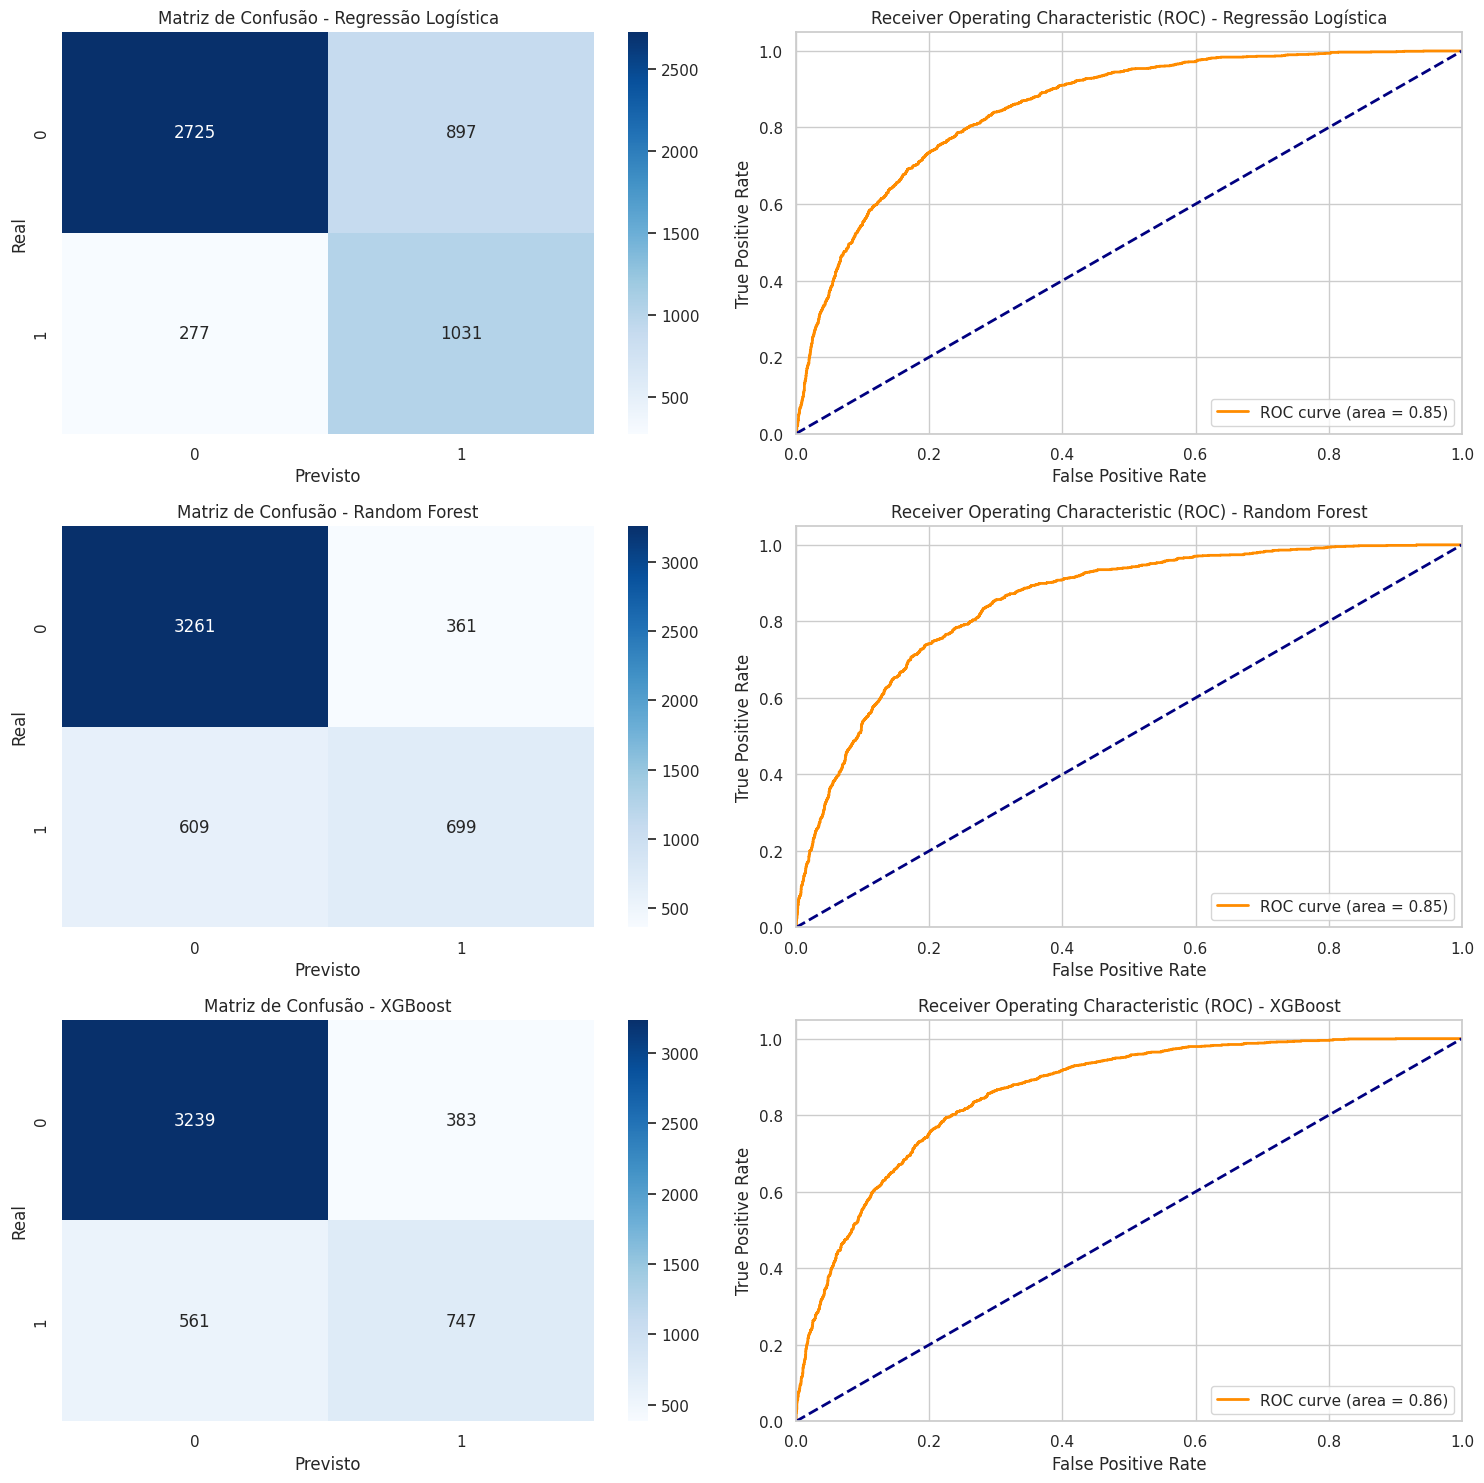

Regressão Logística - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1552
           1       0.54      0.79      0.64       561

    accuracy                           0.77      2113
   macro avg       0.73      0.78      0.74      2113
weighted avg       0.81      0.77      0.78      2113

AUC-ROC: 0.85
Random Forest - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1552
           1       0.68      0.57      0.62       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.75      2113
weighted avg       0.81      0.81      0.81      2113

AUC-ROC: 0.85
XGBoost - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1552
           1       0.68      0.58      0.63       561

    accuracy                           0.82      

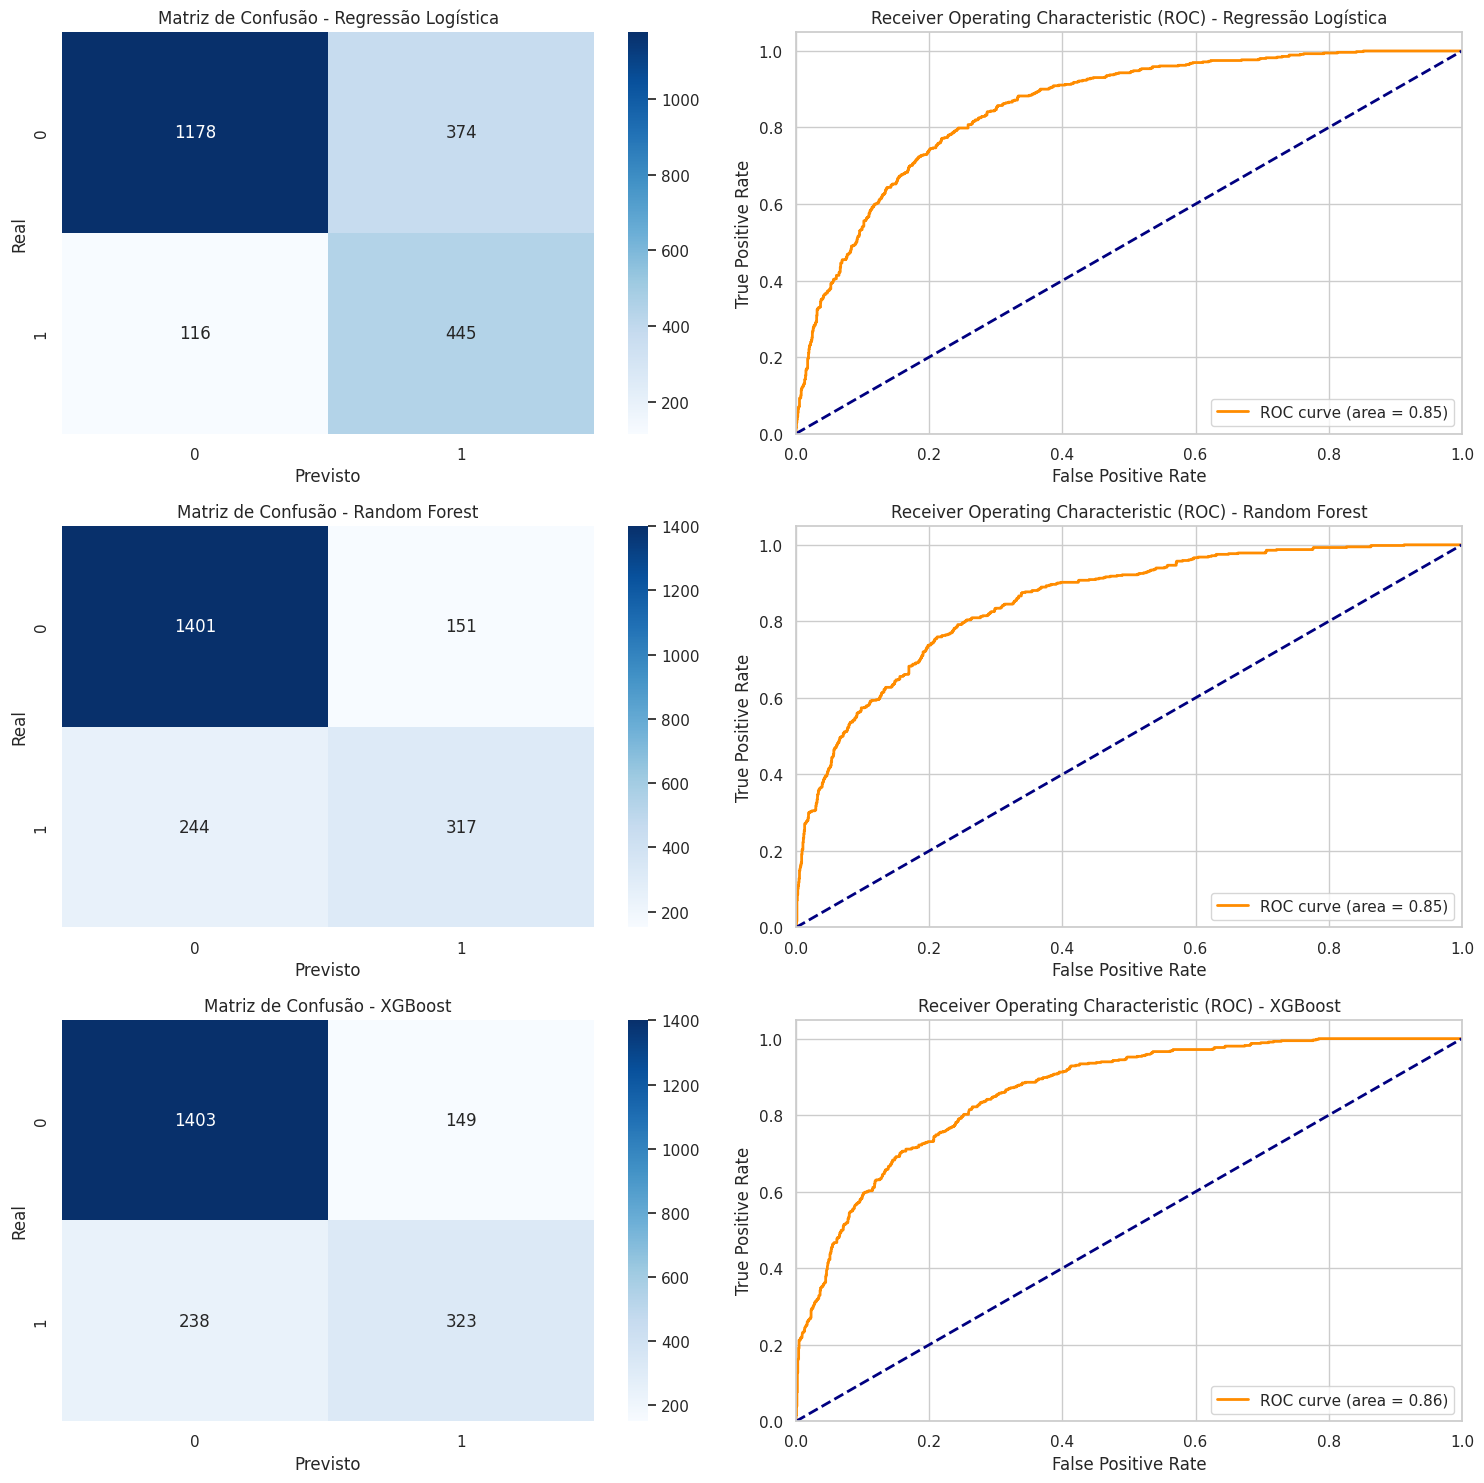

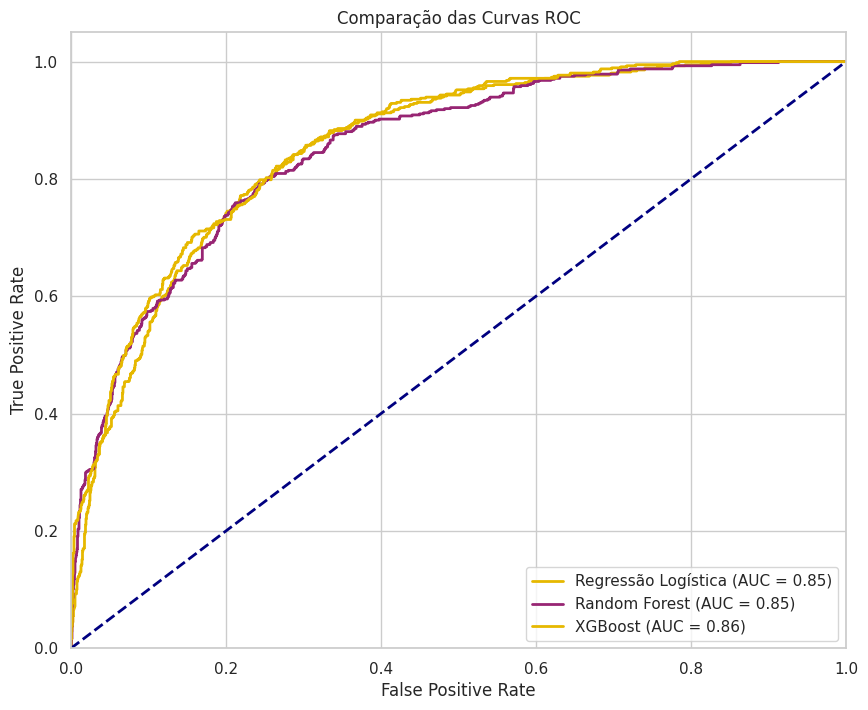

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Separando a base de treino e tese

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, shuffle=True, random_state=42)

# Inicializar os modelos
lg_reg_desbalanced_1 = LogisticRegression(max_iter=100, C=1.0, class_weight= 'balanced',random_state=42)
rf_clf_desbalanced_1 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
xgb_clf_desbalanced_1 = XGBClassifier(learning_rate=None, n_estimators=100, max_depth=1, subsample=0.5, random_state=42)

# Treinar os modelos com os dados balanceados
lg_reg_desbalanced_1.fit(X_train, y_train)
rf_clf_desbalanced_1.fit(X_train, y_train)
xgb_clf_desbalanced_1.fit(X_train, y_train)

# Configurar a validação cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para avaliação com validação cruzada e plotagem
def cross_val_evaluate_and_plot(models, model_names, X_train_res_smote, y_train_res_smote, kf):
    fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)))

    for i, (model, name) in enumerate(zip(models, model_names)):
        y_pred = cross_val_predict(model, X_train, y_train, cv=kf, method='predict')
        y_pred_proba = cross_val_predict(model, X_train, y_train, cv=kf, method='predict_proba')[:, 1]

        print(f"{name}:")
        print(classification_report(y_train, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_train, y_pred_proba):.2f}")

        # Matriz de Confusão
        cm = confusion_matrix(y_train, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
        axes[i, 0].set_xlabel('Previsto')
        axes[i, 0].set_ylabel('Real')
        axes[i, 0].set_title(f'Matriz de Confusão - {name}')

        # Curva ROC e AUC
        fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlim([0.0, 1.0])
        axes[i, 1].set_ylim([0.0, 1.05])
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'Receiver Operating Characteristic (ROC) - {name}')
        axes[i, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Lista de modelos e nomes
models = [lg_reg_desbalanced_1, rf_clf_desbalanced_1, xgb_clf_desbalanced_1]
model_names = ["Regressão Logística", "Random Forest", "XGBoost"]

# Avaliar e plotar
cross_val_evaluate_and_plot(models, model_names, X_train, y_train, kf)

# Função para avaliação no conjunto de teste e plotagem
def evaluate_and_plot_on_test(models, model_names, X_test, y_test):
    fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)))

    for i, (model, name) in enumerate(zip(models, model_names)):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        print(f"{name} - Conjunto de Teste:")
        print(classification_report(y_test, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}")

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
        axes[i, 0].set_xlabel('Previsto')
        axes[i, 0].set_ylabel('Real')
        axes[i, 0].set_title(f'Matriz de Confusão - {name}')

        # Curva ROC e AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlim([0.0, 1.0])
        axes[i, 1].set_ylim([0.0, 1.05])
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'Receiver Operating Characteristic (ROC) - {name}')
        axes[i, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Avaliar e plotar no conjunto de teste
evaluate_and_plot_on_test(models, model_names, X_test, y_test)

# Função para plotagem comparativa das curvas ROC
def plot_comparative_roc(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, model_names):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparação das Curvas ROC')
    plt.legend(loc="lower right")
    plt.show()

# Plotar a comparação das curvas ROC
plot_comparative_roc(models, model_names, X_test, y_test)

# Analisando a acuracia no treino, validação e teste

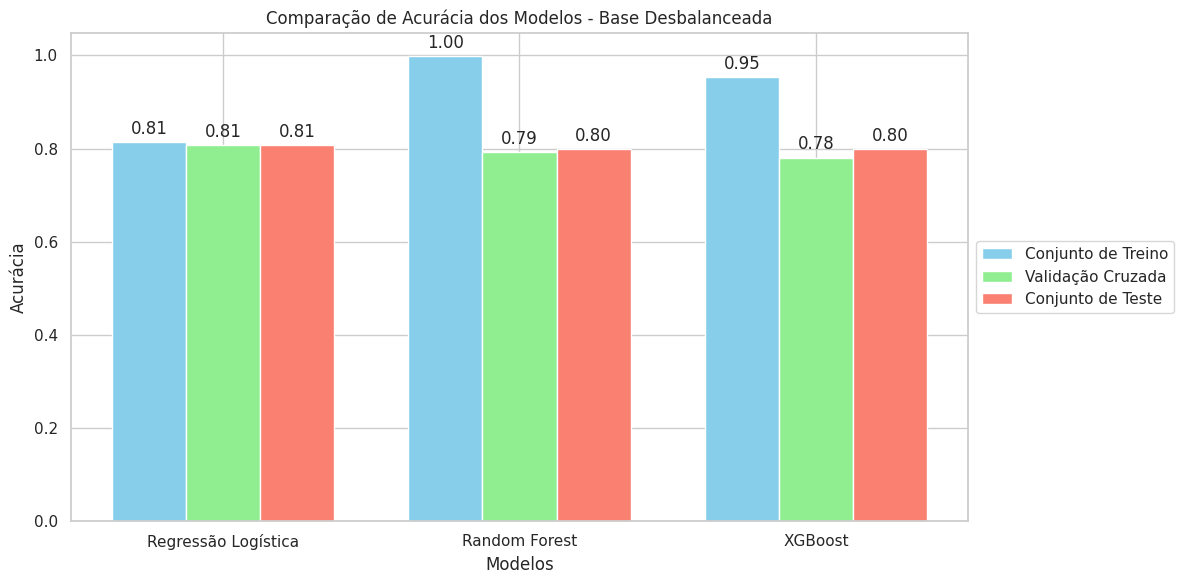

In [ ]:
# Importar bibliotecas necessárias
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Separando a base de treino e tese

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, shuffle=True, random_state=42)
# Lista de modelos e nomes
models = [lg_reg_unbalanced, rf_clf_unbalanced, xgb_clf_unbalanced]
model_names = ["Regressão Logística", "Random Forest", "XGBoost"]

# Inicializar os modelos
lg_reg_desbalanced_accuracy = LogisticRegression(random_state=42)
rf_clf_desbalanced_accuracy = RandomForestClassifier(random_state=42)
xgb_clf_desbalanced_accuracy = XGBClassifier(random_state=42)

# Configurar a validação cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para calcular a acurácia com validação cruzada
def cross_val_accuracy(models, X_train, y_train, kfold):
    accuracies = []
    for model in models:
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        accuracies.append(np.mean(cv_scores))
    return accuracies

# Calcular a acurácia com validação cruzada
models = [lg_reg_unbalanced, rf_clf_unbalanced, xgb_clf_unbalanced]
model_names = ["Regressão Logística", "Random Forest", "XGBoost"]
val_accuracies = cross_val_accuracy(models, X_train, y_train, kfold)

# Treinar os modelos com os dados balanceados
for model in models:
    model.fit(X_train, y_train)

# Calcular a acurácia no conjunto de treino
train_accuracies = [accuracy_score(y_train, model.predict(X_train)) for model in models]

# Calcular a acurácia no conjunto de teste
test_accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models]

# Plotar o gráfico de barras comparando as acurácias
x = np.arange(len(model_names))  # Posições das barras
width = 0.25  # Largura das barras

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_accuracies, width, label='Conjunto de Treino', color='skyblue')
bars2 = ax.bar(x, val_accuracies, width, label='Validação Cruzada', color='lightgreen')
bars3 = ax.bar(x + width, test_accuracies, width, label='Conjunto de Teste', color='salmon')

# Adicionar rótulos, título e legenda
ax.set_xlabel('Modelos')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Acurácia dos Modelos - Base Desbalanceada')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Mover a legenda para o lado direito

# Adicionar rótulos de valor nas barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

## Balanceando a base com metódo SMOTE

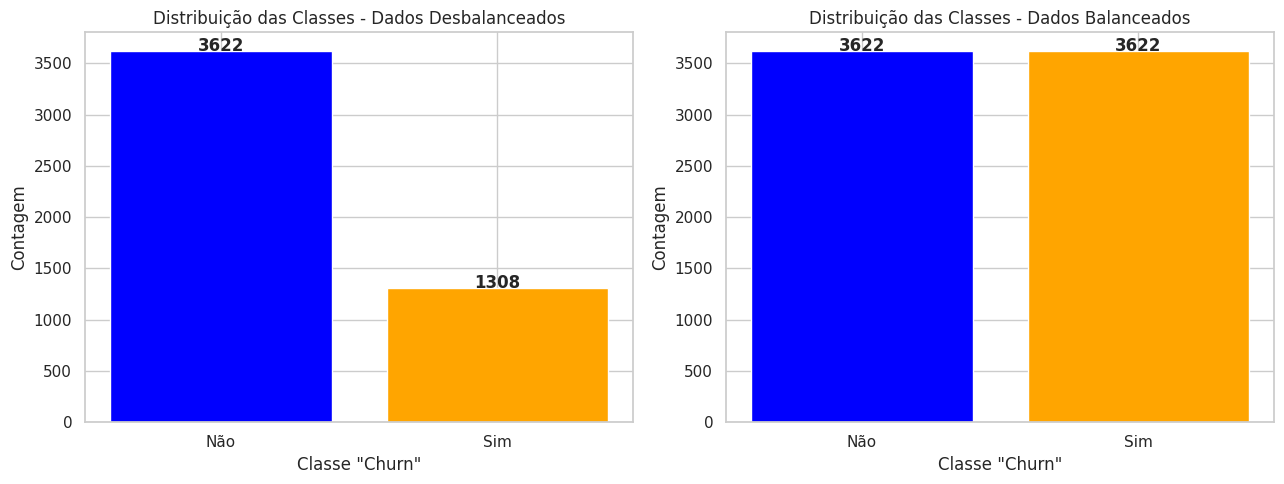

In [ ]:
# Aplicar SMOTE para balancear as classes
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Instanciar modelo de SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE nos dados de treino
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train, y_train)

# Verificar o balanceamento das classes antes e depois do SMOTE
original_counts = pd.Series(y_train).value_counts()
resampled_counts = pd.Series(y_train_res_smote).value_counts()

# Criar subplots para os gráficos de barras
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Gráfico de barras para o conjunto de dados original
ax[0].bar(original_counts.index, original_counts.values, color=['blue', 'orange'])
ax[0].set_title('Distribuição das Classes - Dados Desbalanceados')
ax[0].set_xlabel('Classe "Churn"')
ax[0].set_ylabel('Contagem')
ax[0].set_xticks(original_counts.index)
ax[0].set_xticklabels(['Não', 'Sim'])

# Adicionar contagem acima das barras do gráfico original
for i, v in enumerate(original_counts.values):
    ax[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Gráfico de barras para o conjunto de dados após SMOTE
ax[1].bar(resampled_counts.index, resampled_counts.values, color=['blue', 'orange'])
ax[1].set_title('Distribuição das Classes - Dados Balanceados')
ax[1].set_xlabel('Classe "Churn"')
ax[1].set_ylabel('Contagem')
ax[1].set_xticks(resampled_counts.index)
ax[1].set_xticklabels(['Não', 'Sim'])

# Adicionar contagem acima das barras do gráfico balanceado
for i, v in enumerate(resampled_counts.values):
    ax[1].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lg_reg_balanced = LogisticRegression(random_state=42)

# Criando uma lista de mátricas do Modelo Logistic Regression
lg_bal = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(lg_reg_balanced, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Logistic Regression
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  lg_bal.append(k_result[i].mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_balanced = RandomForestClassifier(random_state=42)

# Criando uma lista de métricas do Modelo Random Forest
rf_bal = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(rf_clf_balanced, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Random Forest
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  rf_bal.append(k_result[i].mean())

In [ ]:
from xgboost import XGBClassifier

xgb_clf_balanced = XGBClassifier(random_state=42)

# Criando uma lista de métricas do Modelo XGBoost
xgb_bal = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(xgb_clf_balanced, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo XGBoost
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  xgb_bal.append(k_result[i].mean())

In [ ]:
#Criando métricas para análise:
metricas_bal = (pd.DataFrame([lg_bal,rf_bal,xgb_bal],
                        index=['Logistic Regression','Random Forest','XG Boost'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metricas_bal

Accuracy  Precision  Recall  F1 Score  AUROC
Logistic Regression     83.49      82.71   84.73     83.69  92.39
Random Forest           85.93      86.63   84.98     85.79  93.47
XG Boost                85.52      85.88   85.04     85.45  93.78

# Testando os modelos na Base de Teste na Base Balanceada sem hiperparâmetros

In [ ]:
# Testar o modelo Logistic Regression com os dados balanceados
lg_reg_balanced.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = lg_reg_balanced.predict(X_test)

lg_corr_bal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1552
           1       0.58      0.65      0.61       561

    accuracy                           0.78      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.78      0.78      2113



In [ ]:
# Testar o modelo Random Forest com os dados balanceados
rf_clf_balanced.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = rf_clf_balanced.predict(X_test)

rf_corr_bal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1552
           1       0.61      0.57      0.59       561

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.72      2113
weighted avg       0.79      0.79      0.79      2113



In [ ]:
# Testar o modelo XGBoost com os dados balanceados
xgb_clf_balanced.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = xgb_clf_balanced.predict(X_test)

xgb_corr_bal = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1552
           1       0.58      0.58      0.58       561

    accuracy                           0.78      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.78      0.78      0.78      2113



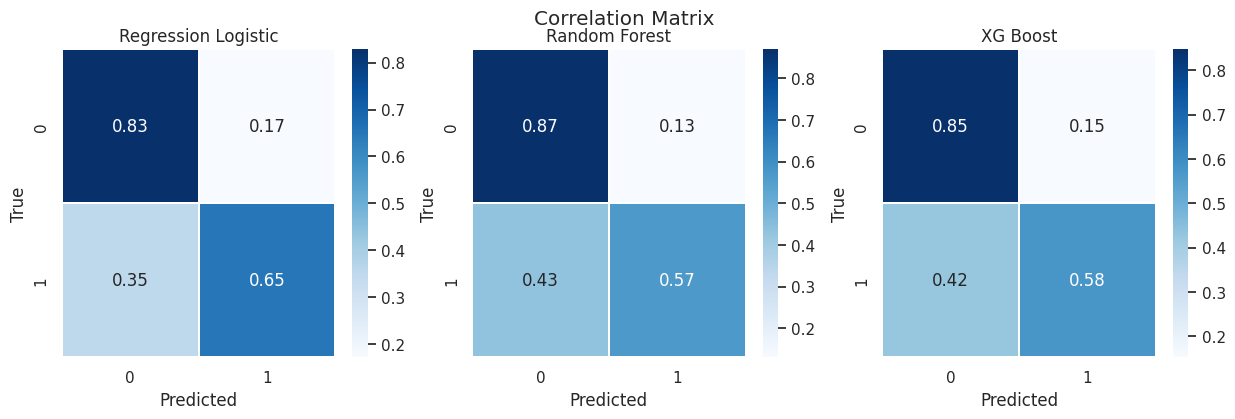

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
fig.suptitle('Correlation Matrix')

sns.heatmap(lg_corr_bal, annot=True, linewidths=.1, cmap='Blues', ax=ax[0])
ax[0].set_title('Regression Logistic')
ax[0].set_ylabel('True')
ax[0].set_xlabel('Predicted')

sns.heatmap(rf_corr_bal, annot=True, linewidths=.1, cmap='Blues', ax=ax[1])
ax[1].set_title('Random Forest')
ax[1].set_ylabel('True')
ax[1].set_xlabel('Predicted')

sns.heatmap(xgb_corr_bal, annot=True, linewidths=.1, cmap='Blues', ax=ax[2])
ax[2].set_title('XG Boost')
ax[2].set_ylabel('True')
ax[2].set_xlabel('Predicted')


plt.show()

Comparando pela área sobre a curva

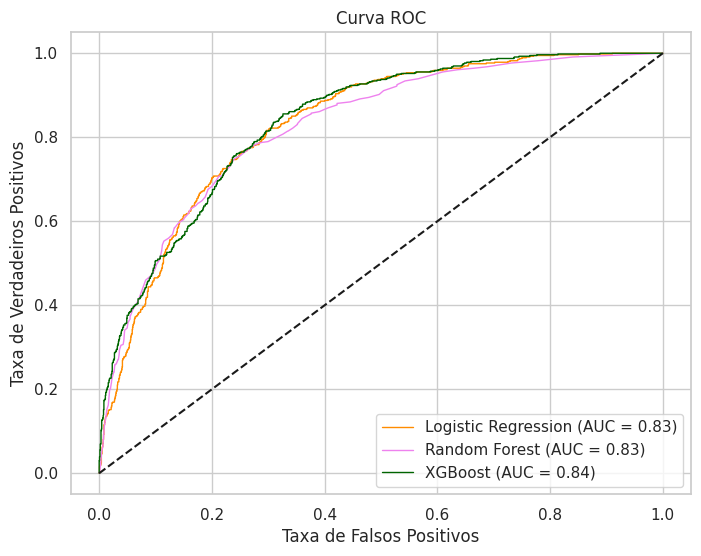

In [ ]:
from sklearn.metrics import roc_curve, auc

# Obter as probabilidades de predição para cada modelo
y_prob_lg = lg_reg_balanced.predict_proba(X_test)[:, 1]
y_prob_rf = rf_clf_balanced.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_clf_balanced.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e AUC para cada modelo
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_prob_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar a curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, color='darkorange', lw=1, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lg)
plt.plot(fpr_rf, tpr_rf, color='violet', lw=1, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=1, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Busca por hiperparâmetros dos modelos para aplicar na base balanceada

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_XGBClassifier_balanced = XGBClassifier(random_state = 42)

# Parameters
params_XGB = {
    'max_depth': [1, 5, 10],
    'n_estimators': [10, 100, 200],
    'subsample': [0.5, 1],
    'learning_rate': [None, 0.01, 0.1]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_XGB_bal = GridSearchCV(estimator=tuned_XGBClassifier_balanced,
                 param_grid=params_XGB,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_XGB_bal.fit(X_train_res_smote, y_train_res_smote)

# Print score dos melhores paramentros
best_recall_bal = GS_XGB_bal.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_bal*100))

# Print melhores parametros
best_parameters_bal = GS_XGB_bal.best_params_
print("Melhores Parametros:", best_parameters_bal)

Best F1 Score: 87.74 %
Melhores Parametros: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 10, 'subsample': 1}


In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_rf_clf_balanced = RandomForestClassifier(random_state=42)

# Parameters
params_rf = {
    'max_depth': [None, 10, 20],
    'n_estimators': [10, 100],
    'min_samples_split': [None, 2, 5, 10]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_rf_bal = GridSearchCV(estimator=tuned_rf_clf_balanced,
                 param_grid=params_rf,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_rf_bal.fit(X_train_res_smote, y_train_res_smote)

# Print score dos melhores paramentros
best_recall_rf = GS_rf_bal.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_rf*100))

# Print melhores parametros
best_parameters_rf = GS_rf_bal.best_params_
print("Melhores Parametros:", best_parameters_rf)

Best F1 Score: 87.44 %
Melhores Parametros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_lg_balanced = LogisticRegression(random_state=42)

# Parameters
params_lg = {
    'C': [None, 0.1, 1.0],
    'max_iter': [100, 1000]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

GS_lg_bal = GridSearchCV(estimator=tuned_lg_balanced,
                 param_grid=params_lg,
                 cv=kfold,
                 scoring='recall')

# Treine o modelo
GS_lg_bal.fit(X_train_res_smote, y_train_res_smote)

# Print score dos melhores paramentros
best_recall_lg = GS_lg_bal.best_score_
print("Best F1 Score: {:.2f} %".format(best_recall_lg*100))

# Print melhores parametros
best_parameters_lg = GS_lg_bal.best_params_
print("Melhores Parametros:", best_parameters_lg)

Best F1 Score: 85.04 %
Melhores Parametros: {'C': 0.1, 'max_iter': 1000}


# Aplicando os modelos com hiperparâmetros

In [ ]:
from sklearn.linear_model import LogisticRegression

lg_reg_balanced_GS = LogisticRegression(C=1.0, max_iter=1000, random_state=42)

# Criando uma lista de mátricas do Modelo Logistic Regression
lg_bal_gs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validating do modelo
k_result = cross_validate(lg_reg_balanced_GS, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Logistic Regression
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  lg_bal_gs.append(k_result[i].mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_balanced_GS = RandomForestClassifier(max_depth=10, n_estimators=100, min_samples_split=10, random_state=42)

# Criando uma lista de métricas do Modelo Random Forest
rf_bal_gs = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross validating do modelo
k_result = cross_validate(rf_clf_balanced_GS, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo Random Forest
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  rf_bal_gs.append(k_result[i].mean())

In [ ]:
from xgboost import XGBClassifier

xgb_clf_balanced_GS = XGBClassifier(learning_rate = None , max_depth=1, n_estimators=10, subsample=1, random_state=42)

# Criando uma lista de métricas do Modelo XGBoost
xgb_bal_gs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross validating do modelo
k_result = cross_validate(xgb_clf_balanced_GS, X_train_res_smote, y_train_res_smote, cv=kfold,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Lista de métricas do modelo XGBoost
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  xgb_bal_gs.append(k_result[i].mean())

In [ ]:
#Criando métricas para análise:
metricas_bal = (pd.DataFrame([lg_bal_gs,rf_bal_gs,xgb_bal_gs],
                        index=['Logistic Regression','Random Forest','XG Boost'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metricas_bal

Accuracy  Precision  Recall  F1 Score  AUROC
Logistic Regression     85.28      85.74   84.65     85.18  93.49
Random Forest           85.63      84.41   87.44     85.89  93.43
XG Boost                80.33      77.76   85.04     81.22  87.86

# Testando os modelos com os hiperparâmetros

In [ ]:
# Testar o modelo Logistic Regression com os dados balanceados
lg_reg_balanced_GS.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = lg_reg_balanced_GS.predict(X_test)

lg_corr_GS = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1552
           1       0.60      0.63      0.62       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.74      2113
weighted avg       0.80      0.79      0.79      2113



In [ ]:
# Testar o modelo Random Forest com os dados balanceados
rf_clf_balanced_GS.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = rf_clf_balanced_GS.predict(X_test)

rf_corr_GS = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1552
           1       0.60      0.67      0.63       561

    accuracy                           0.80      2113
   macro avg       0.74      0.75      0.75      2113
weighted avg       0.80      0.80      0.80      2113



In [ ]:
# Testar o modelo XGBoost com os dados balanceados
xgb_clf_balanced_GS.fit(X_train_res_smote, y_train_res_smote)

y_predXGB = xgb_clf_balanced_GS.predict(X_test)

xgb_corr_GS = confusion_matrix(y_test, y_predXGB, normalize='true')

print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1552
           1       0.52      0.71      0.60       561

    accuracy                           0.75      2113
   macro avg       0.70      0.74      0.71      2113
weighted avg       0.79      0.75      0.76      2113



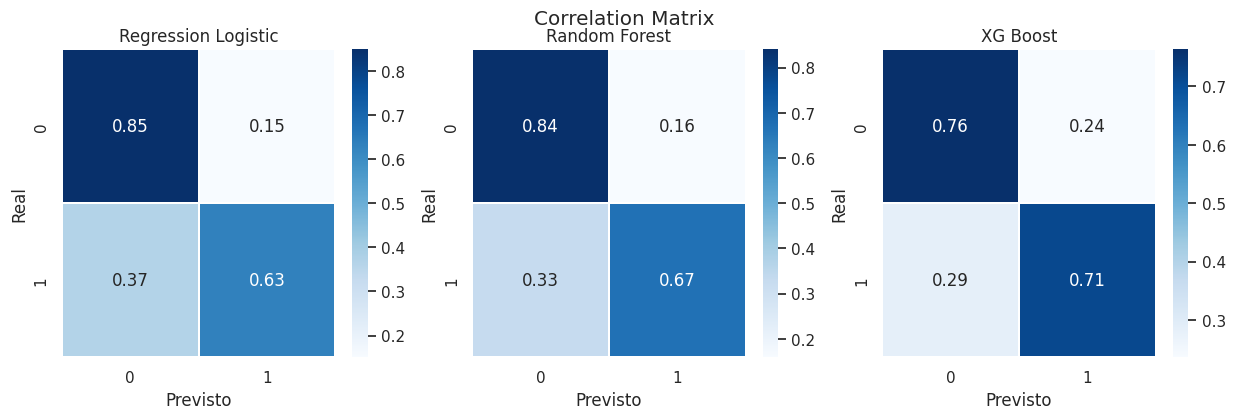

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
fig.suptitle('Correlation Matrix')

sns.heatmap(lg_corr_GS, annot=True, linewidths=.1, cmap='Blues', ax=ax[0])
ax[0].set_title('Regression Logistic')
ax[0].set_ylabel('Real')
ax[0].set_xlabel('Previsto')

sns.heatmap(rf_corr_GS, annot=True, linewidths=.1, cmap='Blues', ax=ax[1])
ax[1].set_title('Random Forest')
ax[1].set_ylabel('Real')
ax[1].set_xlabel('Previsto')

sns.heatmap(xgb_corr_GS, annot=True, linewidths=.1, cmap='Blues', ax=ax[2])
ax[2].set_title('XG Boost')
ax[2].set_ylabel('Real')
ax[2].set_xlabel('Previsto')


plt.show()

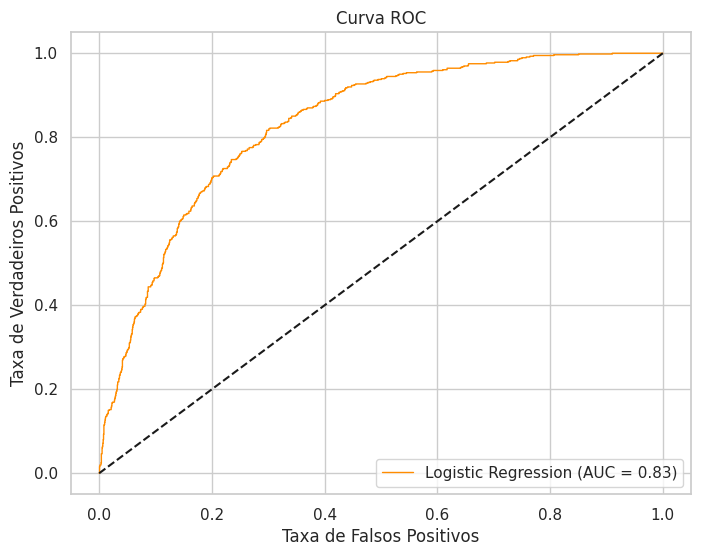

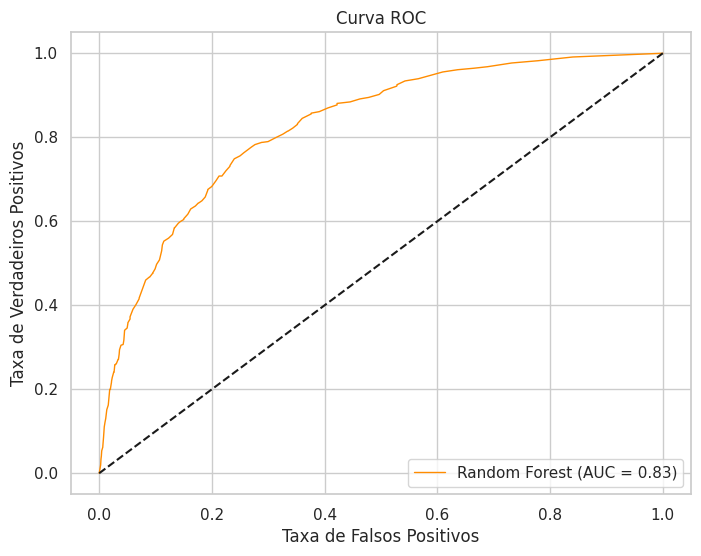

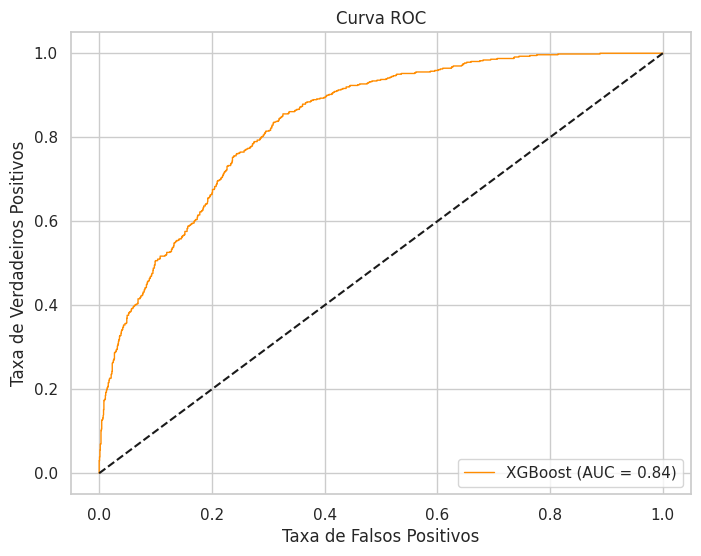

In [ ]:
from sklearn.metrics import roc_curve, auc

# Obter as probabilidades de predição para cada modelo
y_prob_lg_GS = lg_reg_balanced_GS.predict_proba(X_test)[:, 1]
y_prob_rf_GS = rf_clf_balanced_GS.predict_proba(X_test)[:, 1]
y_prob_xgb_GS = xgb_clf_balanced_GS.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e AUC para cada modelo
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_prob_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar a curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, color='darkorange', lw=1, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Plotar a curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Plotar a curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=1, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

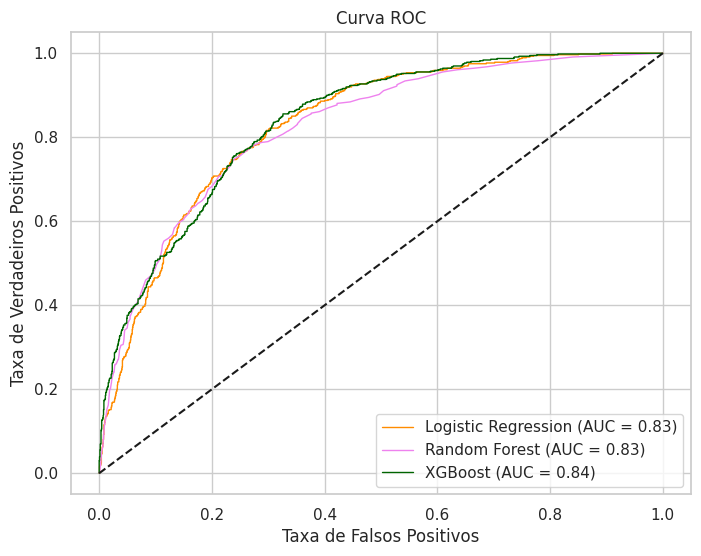

In [ ]:
from sklearn.metrics import roc_curve, auc

# Obter as probabilidades de predição para cada modelo
y_prob_lg_GS = lg_reg_balanced_GS.predict_proba(X_test)[:, 1]
y_prob_rf_GS = rf_clf_balanced_GS.predict_proba(X_test)[:, 1]
y_prob_xgb_GS = xgb_clf_balanced_GS.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e AUC para cada modelo
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_prob_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar a curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, color='darkorange', lw=1, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lg)
plt.plot(fpr_rf, tpr_rf, color='violet', lw=1, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=1, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Aplicando avaliação de overfiting com avaliação da acurácia nos dados de validação e teste | validação e treino - atravé de gráfico de barra

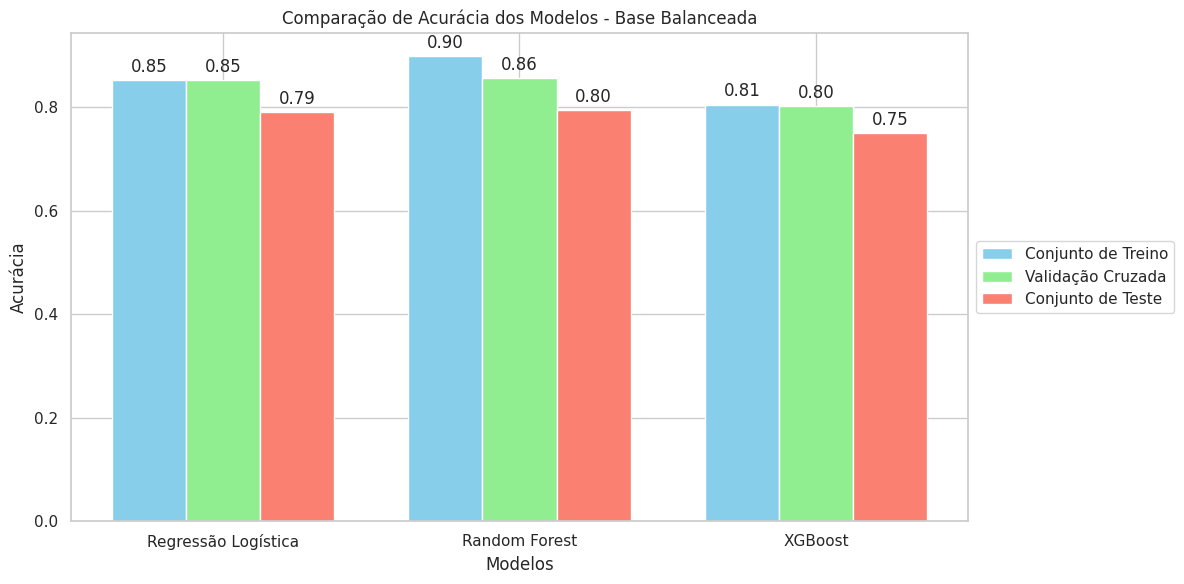

In [ ]:
# Importar bibliotecas necessárias
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train, y_train)

# Inicializar os modelos
lg_reg_balanced_accuracy = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
rf_clf_balanced_accuracy = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
xgb_clf_balanced_accuracy = XGBClassifier(learning_rate=None, n_estimators=10, max_depth=1, subsample=1, random_state=42)

# Configurar a validação cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para calcular a acurácia com validação cruzada
def cross_val_accuracy(models, X_train_res_smote, y_train_res_smote, kfold):
    accuracies = []
    for model in models:
        cv_scores = cross_val_score(model, X_train_res_smote, y_train_res_smote, cv=kfold, scoring='accuracy')
        accuracies.append(np.mean(cv_scores))
    return accuracies

# Calcular a acurácia com validação cruzada
models = [lg_reg_balanced_GS, rf_clf_balanced_GS, xgb_clf_balanced_GS]
model_names = ["Regressão Logística", "Random Forest", "XGBoost"]
val_accuracies = cross_val_accuracy(models, X_train_res_smote, y_train_res_smote, kfold)

# Treinar os modelos com os dados balanceados
for model in models:
    model.fit(X_train_res_smote, y_train_res_smote)

# Calcular a acurácia no conjunto de treino
train_accuracies = [accuracy_score(y_train_res_smote, model.predict(X_train_res_smote)) for model in models]

# Calcular a acurácia no conjunto de teste
test_accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models]

# Plotar o gráfico de barras comparando as acurácias
x = np.arange(len(model_names))  # Posições das barras
width = 0.25  # Largura das barras

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_accuracies, width, label='Conjunto de Treino', color='skyblue')
bars2 = ax.bar(x, val_accuracies, width, label='Validação Cruzada', color='lightgreen')
bars3 = ax.bar(x + width, test_accuracies, width, label='Conjunto de Teste', color='salmon')

# Adicionar rótulos, título e legenda
ax.set_xlabel('Modelos')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Acurácia dos Modelos - Base Balanceada')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Mover a legenda para o lado direito

# Adicionar rótulos de valor nas barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

Regressão Logística:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3622
           1       0.86      0.85      0.85      3622

    accuracy                           0.85      7244
   macro avg       0.85      0.85      0.85      7244
weighted avg       0.85      0.85      0.85      7244

AUC-ROC: 0.93
Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      3622
           1       0.84      0.87      0.86      3622

    accuracy                           0.86      7244
   macro avg       0.86      0.86      0.86      7244
weighted avg       0.86      0.86      0.86      7244

AUC-ROC: 0.93
XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      3622
           1       0.78      0.85      0.81      3622

    accuracy                           0.80      7244
   macro avg       0.81      0.80      0.80      7244
w

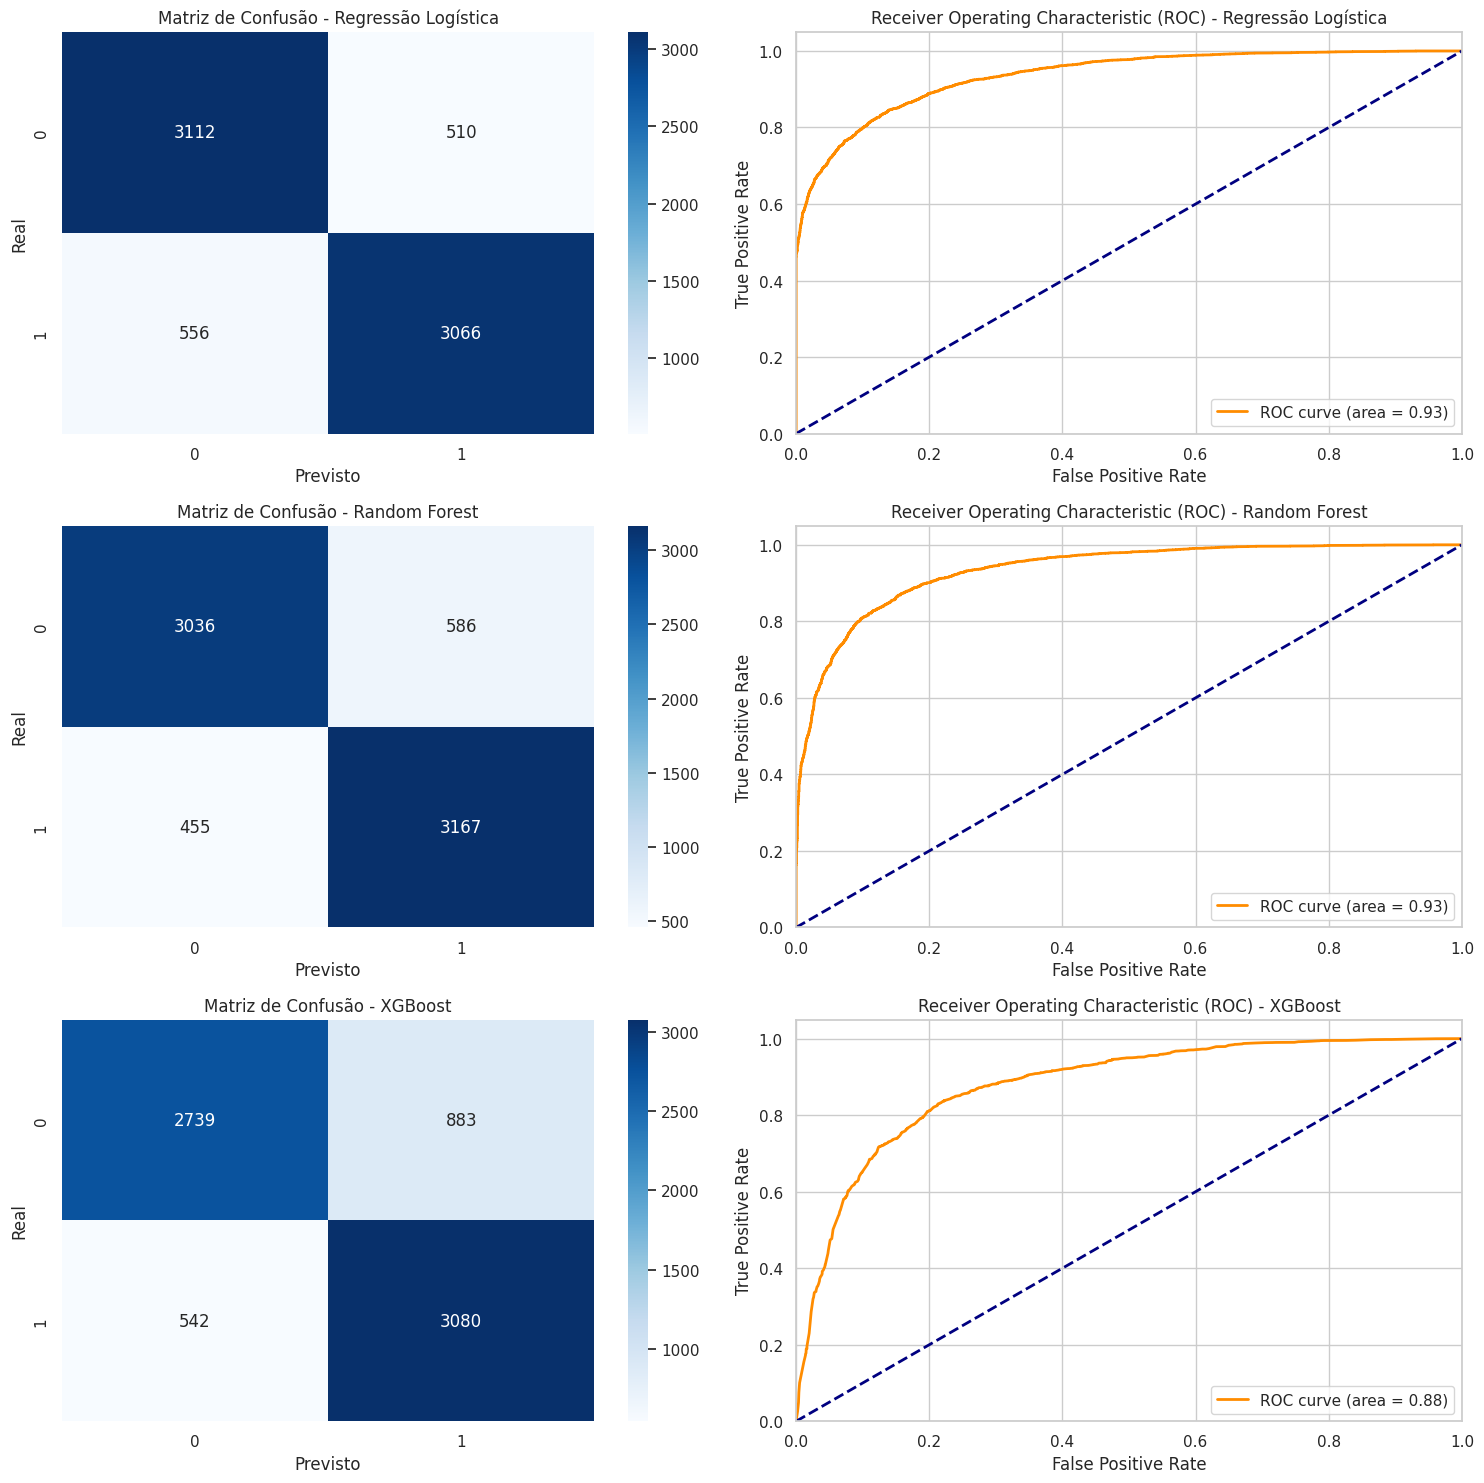

Regressão Logística - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1552
           1       0.60      0.63      0.62       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.74      2113
weighted avg       0.80      0.79      0.79      2113

AUC-ROC: 0.85
Random Forest - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1552
           1       0.60      0.67      0.63       561

    accuracy                           0.80      2113
   macro avg       0.74      0.75      0.75      2113
weighted avg       0.80      0.80      0.80      2113

AUC-ROC: 0.84
XGBoost - Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1552
           1       0.52      0.71      0.60       561

    accuracy                           0.75      

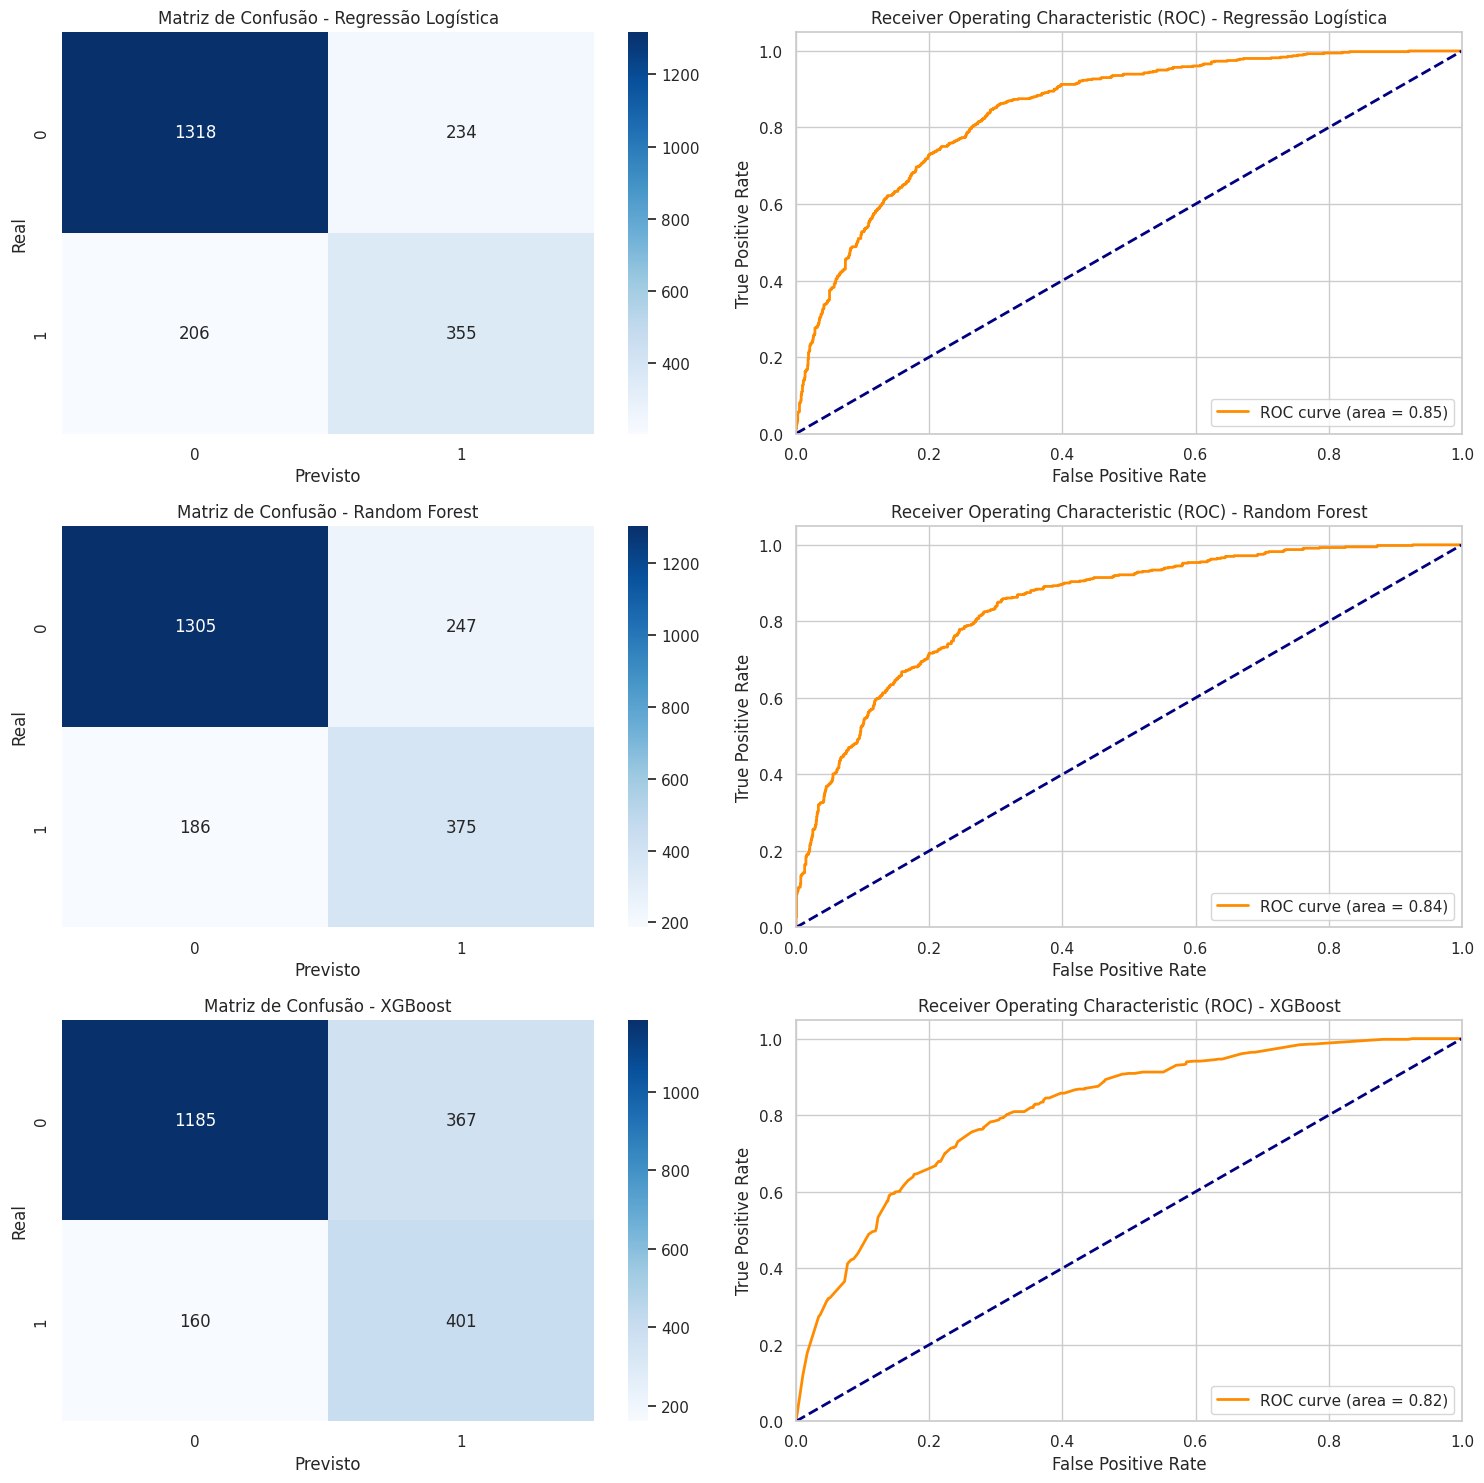

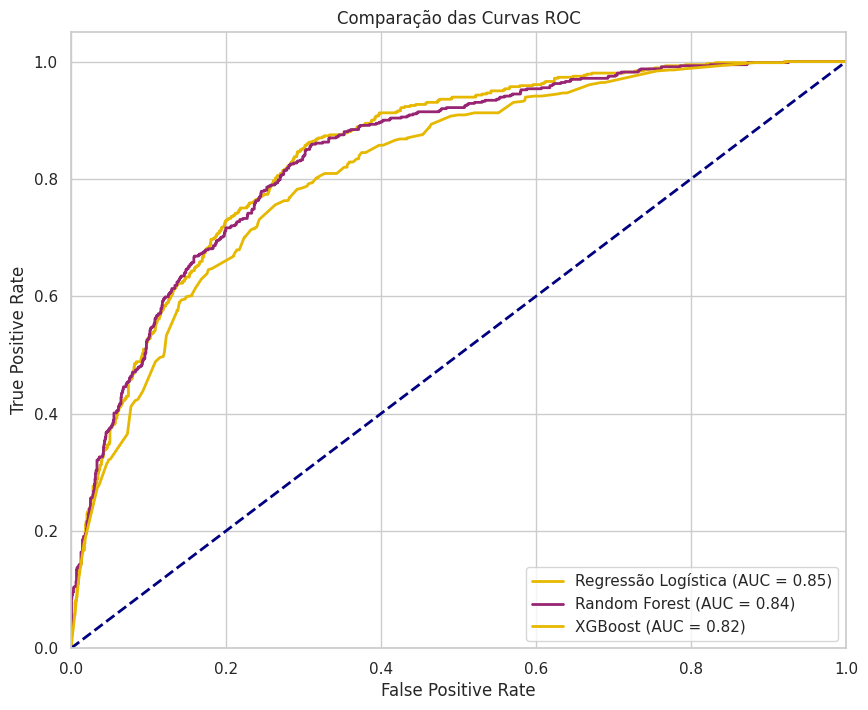

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train, y_train)

# Inicializar os modelos
lg_reg_balanced_2 = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
rf_clf_balanced_2 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
xgb_clf_balanced_2 = XGBClassifier(learning_rate= None, n_estimators=10, max_depth=1, subsample=1, random_state=42)

# Treinar os modelos com os dados balanceados
lg_reg_balanced_2.fit(X_train_res_smote, y_train_res_smote)
rf_clf_balanced_2.fit(X_train_res_smote, y_train_res_smote)
xgb_clf_balanced_2.fit(X_train_res_smote, y_train_res_smote)

# Configurar a validação cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para avaliação com validação cruzada e plotagem
def cross_val_evaluate_and_plot(models, model_names, X_train_res_smote, y_train_res_smote, kf):
    fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)))

    for i, (model, name) in enumerate(zip(models, model_names)):
        y_pred = cross_val_predict(model, X_train_res_smote, y_train_res_smote, cv=kf, method='predict')
        y_pred_proba = cross_val_predict(model, X_train_res_smote, y_train_res_smote, cv=kf, method='predict_proba')[:, 1]

        print(f"{name}:")
        print(classification_report(y_train_res_smote, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_train_res_smote, y_pred_proba):.2f}")

        # Matriz de Confusão
        cm = confusion_matrix(y_train_res_smote, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
        axes[i, 0].set_xlabel('Previsto')
        axes[i, 0].set_ylabel('Real')
        axes[i, 0].set_title(f'Matriz de Confusão - {name}')

        # Curva ROC e AUC
        fpr, tpr, _ = roc_curve(y_train_res_smote, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlim([0.0, 1.0])
        axes[i, 1].set_ylim([0.0, 1.05])
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'Receiver Operating Characteristic (ROC) - {name}')
        axes[i, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Lista de modelos e nomes
models = [lg_reg_balanced_2, rf_clf_balanced_2, xgb_clf_balanced_2]
model_names = ["Regressão Logística", "Random Forest", "XGBoost"]

# Avaliar e plotar
cross_val_evaluate_and_plot(models, model_names, X_train_res_smote, y_train_res_smote, kf)

# Função para avaliação no conjunto de teste e plotagem
def evaluate_and_plot_on_test(models, model_names, X_test, y_test):
    fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)))

    for i, (model, name) in enumerate(zip(models, model_names)):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        print(f"{name} - Conjunto de Teste:")
        print(classification_report(y_test, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}")

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
        axes[i, 0].set_xlabel('Previsto')
        axes[i, 0].set_ylabel('Real')
        axes[i, 0].set_title(f'Matriz de Confusão - {name}')

        # Curva ROC e AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlim([0.0, 1.0])
        axes[i, 1].set_ylim([0.0, 1.05])
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'Receiver Operating Characteristic (ROC) - {name}')
        axes[i, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Avaliar e plotar no conjunto de teste
evaluate_and_plot_on_test(models, model_names, X_test, y_test)

# Função para plotagem comparativa das curvas ROC
def plot_comparative_roc(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, model_names):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparação das Curvas ROC')
    plt.legend(loc="lower right")
    plt.show()

# Plotar a comparação das curvas ROC
plot_comparative_roc(models, model_names, X_test, y_test)